In [1]:
import sys 
from pathlib import Path
import torch
import os
import dill
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os
from pathlib import Path
import cv2
import time

sys.path.append("/home/franka_deoxys/diffusion_policy")
from diffusion_policy.workspace.base_workspace import BaseWorkspace
from diffusion_policy.model.common.rotation_transformer import RotationTransformer
from diffusion_policy.common.pytorch_util import dict_apply
from diffusion_policy.workspace.train_diffusion_unet_hybrid_workspace import TrainDiffusionUnetHybridWorkspace


sys.path.append("/home/franka_deoxys/deoxys_control/deoxys")
from deoxys import config_root
from deoxys.franka_interface import FrankaInterface
from deoxys.utils import  YamlConfig
from deoxys.utils.config_utils import robot_config_parse_args
from deoxys.utils.input_utils import input2action
from deoxys.utils.io_devices import SpaceMouse
from deoxys.utils.log_utils import get_deoxys_example_logger
from deoxys.experimental.motion_utils import follow_joint_traj, reset_joints_to

sys.path.append("/home/franka_deoxys/deoxys_vision")
from deoxys_vision.networking.camera_redis_interface import CameraRedisSubInterface
from deoxys_vision.utils.camera_utils import assert_camera_ref_convention, get_camera_info


from util_eval import RobotStateRawObsDictGenerator, FrameStackForTrans

np.set_printoptions(precision=3, suppress=True)

logger = get_deoxys_example_logger()

/home/franka_deoxys/miniconda3/envs/robodiff_2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
args = robot_config_parse_args()
robot_interface = FrankaInterface(os.path.join(config_root, args.interface_cfg))
controller_cfg = YamlConfig(
    os.path.join(config_root, args.controller_cfg)
).as_easydict()
controller_type = args.controller_type



In [4]:
# spacemouse = SpaceMouse(vendor_id=9583, product_id=50734) 
#old spacemoue not wireless
spacemouse = SpaceMouse(vendor_id=9583, product_id=50770)
spacemouse.start_control()
raw_obs_dict_generator = RobotStateRawObsDictGenerator()

Opening SpaceMouse device
Manufacturer: 3Dconnexion
Product: 3Dconnexion Universal Receiver

Control                       	Command
Right button                  	reset simulation
Left button (hold)            	close gripper
Move mouse laterally          	move arm horizontally in x-y plane
Move mouse vertically         	move arm vertically
Twist mouse about an axis     	rotate arm about a corresponding axis
ESC                           	quit



In [5]:
def set_gripper(open=True):
    d=-1. if open else 1.0
    action_close=np.array([ 0.,  0., -0.,  0.,  0., -0., d])
    robot_interface.control(
        controller_type=controller_type,
        action=action_close,
        controller_cfg=controller_cfg,
    )

### reset robot position (no need to do it from terminal)

In [6]:
# copied from reset_robot_joints.py
# Golden resetting joints
reset_joint_positions = [
        0.037,-1.655,0.099,-2.993,-0.074,2.321,0.921]

# reset_joint_positions= [0.03492503,-1.64946574,0.09731048,-2.99831706,
#                         0.06887073,2.31927159,0.91575789]

In [6]:
reset_joints_to(robot_interface, reset_joint_positions)
# set_gripper(open=True)

JOINT_POSITION


True

In [6]:
if robot_interface._state_buffer:
    last_state = robot_interface._state_buffer[-1]
else:
    print("The state buffer is empty.")
    

### getting lowdim obs + camera obs

In [11]:
camera_ids = [0,1]
# camera_ids = [0]
cr_interfaces = {}

use_depth = False
for camera_id in camera_ids:
    camera_ref=f"rs_{camera_id}"
    assert_camera_ref_convention(camera_ref)
    camera_info = get_camera_info(camera_ref)
    print('---------****-----------')
    print(camera_info)
    print('--------------------------')
    # camera_info=  {'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'}
# 

    cr_interface = CameraRedisSubInterface(camera_info=camera_info, use_depth=use_depth, redis_host='127.0.0.1')
    cr_interface.start()
    cr_interfaces[camera_id] = cr_interface


def get_imgs(use_depth=False):
    data = {}
    for camera_id in camera_ids:
        img_info = cr_interfaces[camera_id].get_img_info()
        data[f"camera_{camera_id}"]=img_info

        imgs = cr_interfaces[camera_id].get_img()
    
        color_img = imgs["color"][..., ::-1]
        
        # color_img = cv2.resize(color_img, (128, 128))  
        # depth_img = cv2.resize(depth_img, (128, 128))
        
        # color_img = cv2.resize(color_img, ) 


        # color_img = cv2.resize(color_img, (224, 224), fx=0.5, fy=0.5)

        color_img = cv2.resize(color_img, (320, 240))

        data[f"camera_{camera_id}_color"]=color_img

        if use_depth:
            depth_img = imgs["depth"]
            depth_img = cv2.resize(depth_img, (224, 224)) 
            data[f"camera_{camera_id}_depth"]=depth_img
    return data

---------****-----------
{'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'}
--------------------------
CameraRedisSubInterface:: {'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'} True False
---------****-----------
{'camera_id': 1, 'camera_type': 'rs', 'camera_name': 'camera_rs_1'}
--------------------------
CameraRedisSubInterface:: {'camera_id': 1, 'camera_type': 'rs', 'camera_name': 'camera_rs_1'} True False


keys:  dict_keys(['camera_0', 'camera_0_color', 'camera_1', 'camera_1_color'])
(240, 320, 3)


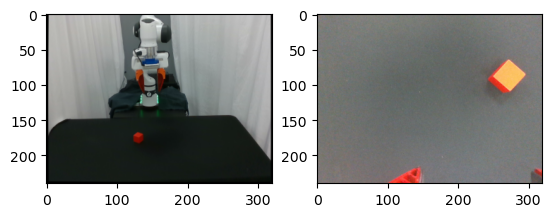

In [12]:
data = get_imgs()
print('keys: ', data.keys())

img_wrist = data['camera_0_color']
img_front = data['camera_1_color']

agentview_rgb=img_wrist 
eye_in_hand_rgb=img_front
print(eye_in_hand_rgb.shape)

# new= eye_in_hand_rgb.transpose(0, 1, 2)

plt.subplot(121)
plt.imshow(agentview_rgb[:,:,::-1])
plt.subplot(122)
plt.imshow(eye_in_hand_rgb[:,:,::-1])

In [40]:
def get_current_obs(robot_interface):
    last_state = robot_interface._state_buffer[-1]
    # print(last_state)
    last_gripper_state = robot_interface._gripper_state_buffer[-1]
    
    obs_dict = raw_obs_dict_generator.get_raw_obs_dict(
    {"last_state": last_state, "last_gripper_state": last_gripper_state})
    # obs_dict={} #rgb only 

    data = get_imgs()
    img_wrist = data['camera_0_color']
    img_front = data['camera_1_color']

    agentview_rgb=img_wrist
    eye_in_hand_rgb=img_front
    # eye_in_hand_rgb[:, :, [0, 2]] = eye_in_hand_rgb[:, :, [2, 0]]
    # agentview_rgb=cv2.resize(img_wrist, (120, 120))  
    # eye_in_hand_rgb=cv2.resize(img_front, (120, 120)) 

    # agentview_rgb.shape, eye_in_hand_rgb.shape

    obs_dict['agentview_rgb']=agentview_rgb.transpose(2, 1, 0)
    obs_dict['eye_in_hand_rgb']=eye_in_hand_rgb.transpose(2, 1, 0)
    return obs_dict

obs_dict=get_current_obs(robot_interface)
for key in obs_dict.keys():
    obs_dict[key]=obs_dict[key][None]
    print(key, obs_dict[key].shape)

ee_states (1, 16)
joint_states (1, 7)
gripper_states (1, 1)
agentview_rgb (1, 3, 320, 240)
eye_in_hand_rgb (1, 3, 320, 240)


### Now load dp policy

In [15]:

# checkpoint = '/home/franka_deoxys/train_dp_bg_removed/after_train_500_epochs.ckpt'
# checkpoint= '/home/franka_deoxys/riad/diffusion_policy/duck_train/epoch_400_20250227_225952.ckpt'
# checkpoint= '/home/franka_deoxys/riad/after_train_100_epochs.ckpt'
# checkpoint = '/home/franka_deoxys/riad/duck_65_checkpoint/after_train_300_epochs.ckpt'
# checkpoint = '/home/franka_deoxys/riad/duck_50_checkpoint/after_train_150_epochs.ckpt'
# checkpoint= '/home/franka_deoxys/riad/duck_56_checkpoint/after_train_300_epochs.ckpt'
# checkpoint = '/home/franka_deoxys/riad/duck_92_checkpoints/densed/after_train_200_epochs.ckpt'
# checkpoint = '/home/franka_deoxys/riad/duck_36_checkpoints/after_train_150_epochs.ckpt'
# checkpoint = '/home/franka_deoxys/riad/duck_36_checkpoints/new_15_3_25/after_train_400_epochs.ckpt'
# checkpoint = '/home/franka_deoxys/riad/duck_92_checkpoints/new_15_03_25/epoch_400_20250315_054547.ckpt'
# checkpoint= '/home/franka_deoxys/riad/candy_35/after_train_200_epochs.ckpt' # candy
# checkpoint = '/home/franka_deoxys/riad/candy_75/epoch_200_20250319_212844.ckpt' #candy
# checkpoint = '/home/franka_deoxys/riad/candy_75/after_train_300_epochs.ckpt' #candy
# checkpoint = '/home/franka_deoxys/riad/block/after_train_200_epochs.ckpt' # block
checkpoint = '/home/franka_deoxys/riad/block/both_views/epoch_100_20250320_221135.ckpt' #block both view
payload = torch.load(open(checkpoint, 'rb'), pickle_module=dill)
cfg = payload['cfg'] 
workspace = TrainDiffusionUnetHybridWorkspace(cfg, output_dir=None)
workspace: BaseWorkspace
workspace.load_payload(payload, exclude_keys=None, include_keys=None)


============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['ee_states', 'gripper_states', 'joint_states']
using obs modality: rgb with keys: ['eye_in_hand_rgb', 'agentview_rgb']
using obs modality: depth with keys: []
using obs modality: scan with keys: []


/home/franka_deoxys/miniconda3/envs/robodiff_2/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/franka_deoxys/miniconda3/envs/robodiff_2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Diffusion params: 6.735348e+07
Vision params: 2.239418e+07


In [16]:
# get policy from workspace
policy = workspace.model
if cfg.training.use_ema:
    policy = workspace.ema_model

device = torch.device(device)
policy.to(device)
policy.eval()
pass 

In [17]:
rotation_transformer = RotationTransformer('axis_angle', 'rotation_6d')

def undo_transform_action( action):
    raw_shape = action.shape
    if raw_shape[-1] == 20:
        # dual arm
        action = action.reshape(-1,2,10)

    d_rot = action.shape[-1] - 4
    pos = action[...,:3]
    rot = action[...,3:3+d_rot]
    gripper = action[...,[-1]]
    rot = rotation_transformer.inverse(rot)
    uaction = np.concatenate([
        pos, rot, gripper
    ], axis=-1)

    if raw_shape[-1] == 20:
        # dual arm
        uaction = uaction.reshape(*raw_shape[:-1], 14)

    return uaction


def predict_action(obs):
    """ 
    obs: 2x...
    """
    np_obs_dict = {key:obs[key] for key in keys_select}
    obs_dict = dict_apply(np_obs_dict, 
        lambda x: torch.from_numpy(x).to(
            device=device))

    for key in obs_dict.keys():
        obs_dict[key]=obs_dict[key].unsqueeze(0) 

    
    with torch.no_grad():
        
        action_dict = policy.predict_action(obs_dict)

    # device_transfer
    np_action_dict = dict_apply(action_dict, lambda x: x.detach().to('cpu').numpy())


    # step env
    env_action =  np_action_dict['action']
    env_action = undo_transform_action(env_action)

    env_action=env_action.squeeze()
    return env_action

### test prediction on a obs

In [41]:
framestacker=FrameStackForTrans(2)
keys_select = ['agentview_rgb', 'joint_states', 'ee_states', 'eye_in_hand_rgb', 'gripper_states']
# keys_select = ['eye_in_hand_rgb', 'gripper_states']

obs_dict=get_current_obs(robot_interface)
for key in obs_dict.keys(): 
    print(key, obs_dict[key].shape)

# keys_select = [ 'joint_states', 'ee_states', 'eye_in_hand_rgb', 'gripper_states']
framestacker=FrameStackForTrans(2) 
policy.reset()

obs_dict=get_current_obs(robot_interface)
obs = framestacker.reset(obs_dict)
obs_dict=get_current_obs(robot_interface)
obs = framestacker.add_new_obs(obs_dict)

# plt.subplot(121)
# plt.imshow(obs['eye_in_hand_rgb'][0].transpose(1,2,0))

# plt.subplot(122)
# plt.imshow(obs['eye_in_hand_rgb'][1].transpose(1,2,0))
action_pred=predict_action(obs)
action_pred

ee_states (16,)
joint_states (7,)
gripper_states (1,)
agentview_rgb (3, 320, 240)
eye_in_hand_rgb (3, 320, 240)


array([[-0.   , -0.133, -0.142,  0.012, -0.024, -0.002, -1.   ],
       [ 0.029, -0.121, -0.145,  0.018, -0.007, -0.012, -0.979],
       [ 0.067, -0.122, -0.162, -0.008, -0.017, -0.013, -0.992],
       [ 0.057, -0.116, -0.156,  0.005, -0.018, -0.014, -1.   ],
       [ 0.082, -0.111, -0.179, -0.006, -0.034, -0.023, -1.   ],
       [ 0.075, -0.079, -0.172, -0.013, -0.022, -0.015, -0.998],
       [ 0.085, -0.049, -0.19 , -0.01 , -0.027, -0.01 , -0.986],
       [ 0.1  , -0.018, -0.178, -0.022, -0.025, -0.015, -0.993]],
      dtype=float32)

In [46]:
print(obs['eye_in_hand_rgb'].shape)
print(obs['eye_in_hand_rgb'][-1,:,:,::-1].shape)

(2, 3, 320, 240)
(3, 320, 240)


Safety Check

In [14]:
import time
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import ConvexHull
from scipy.spatial.transform import Rotation as R

###############################################################################
# 1) (Unchanged) Forward Kinematics & Safe-Set Utilities
###############################################################################
def dh_transform(a, alpha, d, theta):
    return np.array([
        [ np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha),  a*np.cos(theta)],
        [ np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha),  a*np.sin(theta)],
        [ 0,              np.sin(alpha),                np.cos(alpha),                d              ],
        [ 0,              0,                            0,                            1              ]
    ], dtype=float)


def franka_forward_kinematics(joint_angles):
    """
    Returns a 4x4 transform from the panda base to the 'panda_hand' link.
    """
    q1, q2, q3, q4, q5, q6, q7 = joint_angles
    
    # DH transforms up to the flange (link8 in the URDF).
    T1 = dh_transform(a=0,       alpha=0,         d=0.333,   theta=q1)
    T2 = dh_transform(a=0,       alpha=-np.pi/2,  d=0,       theta=q2)
    T3 = dh_transform(a=0,       alpha=np.pi/2,   d=0.316,   theta=q3)
    T4 = dh_transform(a=0.0825,  alpha=np.pi/2,   d=0,       theta=q4)
    T5 = dh_transform(a=-0.0825, alpha=-np.pi/2,  d=0.384,   theta=q5)
    T6 = dh_transform(a=0,       alpha=np.pi/2,   d=0,       theta=q6)
    T7 = dh_transform(a=0.088,   alpha=np.pi/2,   d=0,       theta=q7)
    
    # Flange offset (link8).
    T_flange = dh_transform(a=0, alpha=0, d=0.107, theta=0)
    
    # Extra rotation from flange -> panda_hand (about Z by -π/4).
    Rz_neg_45 = dh_transform(a=0, alpha=0, d=0, theta=-np.pi/4)

    T_panda_hand = T1 @ T2 @ T3 @ T4 @ T5 @ T6 @ T7 @ T_flange @ Rz_neg_45
    return T_panda_hand

def joint_angles_to_end_effector_pose(joint_angles):
    """
    Convert 7 Franka joint angles -> [x, y, z, qx, qy, qz, qw].
    (Exactly the same as in your safe-set code.)
    """
    T = franka_forward_kinematics(joint_angles)
    x, y, z = T[0, 3], T[1, 3], T[2, 3]
    rot_mat = T[:3, :3]
    quat = R.from_matrix(rot_mat).as_quat()  # [qx, qy, qz, qw]
    return np.array([x, y, z, quat[0], quat[1], quat[2], quat[3]], dtype=float)

def normalize_quaternion(q):
    norm = np.linalg.norm(q)
    return q / norm if norm > 1e-6 else np.array([0, 0, 0, 1])

def pose7d_to_6d(pose7d):
    """
    Convert a 7D pose (position + quaternion) to a minimal 6D representation:
    [x, y, z, rx, ry, rz] where (rx, ry, rz) is the rotation vector.
    """
    pos = pose7d[:3]
    quat = pose7d[3:7]
    norm = np.linalg.norm(quat)
    quat = quat / norm if norm > 1e-6 else np.array([0, 0, 0, 1])
    rotvec = R.from_quat(quat).as_rotvec()
    return np.hstack([pos, rotvec])

def load_safe_set(file_path="safe_set_6d.npz"):
    data = np.load(file_path)
    return data["safe_set"], data["hull_equations"], data["hull_vertices"]

def is_pose_in_safe_set_6d(query_6d, hull_equations, tol=1e-8):
    A = hull_equations[:, :-1]  # shape (m,6)
    b = hull_equations[:, -1]   # shape (m,)
    norms = np.linalg.norm(A, axis=1)
    distances = (A.dot(query_6d) + b) / norms
    inside = np.all(distances <= tol)
    return inside, distances

###############################################################################
# 2) Visualization (optional, unchanged from your snippet)
###############################################################################
def visualize_policy_predictions(safe_set, predicted_poses_7d, inside_flags, title="Policy Predictions vs. Safe Set"):
    hull_3d = ConvexHull(safe_set[:, :3])
    fig = go.Figure()
    fig.add_trace(go.Mesh3d(
        x=safe_set[:, 0],
        y=safe_set[:, 1],
        z=safe_set[:, 2],
        i=hull_3d.simplices[:, 0],
        j=hull_3d.simplices[:, 1],
        k=hull_3d.simplices[:, 2],
        opacity=0.3,
        color='lightblue',
        name='Safe Set Hull'
    ))
    predicted_positions = predicted_poses_7d[:, :3]
    colors = ["green" if flag else "red" for flag in inside_flags]
    fig.add_trace(go.Scatter3d(
        x=predicted_positions[:, 0],
        y=predicted_positions[:, 1],
        z=predicted_positions[:, 2],
        mode='markers+lines',
        marker=dict(size=5, color=colors),
        line=dict(color='gray', width=2),
        name='EEF Poses (Real Joints)'
    ))
    fig.update_layout(
        title=title,
        scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z")
    )
    fig.show()


def push_pose_outside_safe_set_7d(pose_7d, hull_equations, margin=1e-3, tol=1e-8):
    """
    If pose_7d is inside the safe set, push it slightly outside along the facet
    with the largest distance. This ensures the resulting pose is outside by
    at least 'margin'.

    pose_7d: [x,y,z, qx,qy,qz,qw]
    hull_equations: from your .npz file => hull_equations
    margin: how far beyond the hull to push
    tol: tolerance to treat as "inside"

    Returns:
      new_pose_7d: The pose (7D) guaranteed to be outside the safe set.
    """
    # 1) Convert to 6D (pos + rotation vector)
    pose_6d = pose7d_to_6d(pose_7d)
    inside, distances = is_pose_in_safe_set_6d(pose_6d, hull_equations, tol)
    if not inside:
        # Already outside => return as-is
        return pose_7d

    # 2) Find the facet with the maximum distance
    #    Typically, distances for an inside point are <= 0 or negative, but we pick
    #    the largest anyway. We'll push along that normal.
    i_max = np.argmax(distances)
    d_max = distances[i_max]
    A_i = hull_equations[i_max, :-1]   # normal vector
    norm_A = np.linalg.norm(A_i)

    # 3) Compute shift => we move (tol - d_max + margin) along the normal
    #    so that the new point is just outside by 'margin'.
    shift_6d = ((tol - d_max) + margin) * (A_i / norm_A)
    pose_6d_out = pose_6d + shift_6d

    # 4) Convert back to 7D => new position + orientation
    new_pos = pose_6d_out[:3]
    new_rotvec = pose_6d_out[3:]
    new_quat = R.from_rotvec(new_rotvec).as_quat()
    new_pose_7d = np.hstack([new_pos, new_quat])
    return new_pose_7d

safe_set_file="Safe_diffusion_policy/safe_set_6d_dummy.npz"
safe_set, hull_equations, _ = load_safe_set(safe_set_file)

In [16]:
reset_joint_positions_0 = [-0.03,0.244,-0.03,
                               -1.673,0.134,1.905,0.665]

# reset_joint_positions_0 = [-0.047,0.529,-0.061,-1.458,0.165,1.992,0.661]

In [ ]:
# reset_joint_positions_d = [-0.03,0.244,-0.03,-1.673,0.134,1.905,0.665]

In [20]:
reset_joint_positions_b= [0.034,0.109,-0.012,-1.63,0.005,1.776,0.696]

In [37]:
# # reset robot
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions_0)
set_gripper(open=True)
policy.reset()

JOINT_POSITION


In [ ]:
# # # reset robot
# set_gripper(open=True)
# reset_joints_to(robot_interface, reset_joint_positions)
# set_gripper(open=True)
# policy.reset()

JOINT_POSITION


In [56]:
# # reset robot
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions_b)
set_gripper(open=True)


JOINT_POSITION


### Now run inference in loop

In [ ]:
framestacker=FrameStackForTrans(2) 
policy.reset()
obs_dict=get_current_obs(robot_interface)
obs = framestacker.reset(obs_dict)
obs_dict=get_current_obs(robot_interface)
obs = framestacker.add_new_obs(obs_dict)
# policy.reset()
# # reset robot
images = []
all_poses_7d = []
all_inside_flags = []

for _ in range(1000):
    # 1) Acquire user input
    # action, grasp = input2action(device=spacemouse, controller_type=controller_type)
    # if action is None:
    #     break
    if len(robot_interface._state_buffer) == 0:
        continue

    # 2) Get observation
    obs_dict = get_current_obs(robot_interface)
    img = obs_dict['eye_in_hand_rgb']
    # img = img.transpose(2, 1, 0)
    print(img.shape)
    # plt.subplot(111)
    # plt.imshow(img)
    images.append(img)
    obs = framestacker.add_new_obs(obs_dict)
    # print(obs)

    # 3) Policy predicts an action (whatever format: delta pose, EEF pose, etc.)
    #    We'll send it to the robot
    action_pred = predict_action(obs)  # shape is up to your policy
    # print("Raw policy prediction:", action_pred)

    

    # 4) Let's say we control the robot with the first 4 predicted actions
    for i, single_cmd in enumerate(action_pred):
        print(f"action {i} =>", single_cmd)
        robot_interface.control(
            controller_type=controller_type,
            action=single_cmd,
            controller_cfg=controller_cfg,
        )

        # (Optional) short delay for the robot to move
        time.sleep(0.08)

        # 5) Now read the *actual* real joint angles from the robot
        #    e.g. shape (7,) => [q1, q2, q3, q4, q5, q6, q7]
        js_real = robot_interface.last_q  
        if js_real is None:
            print("No joint angles read. Skipping.")
            continue

        # # 6) Convert those real joints => 7D EEF pose => 6D => safe-set check
        eef_pose_7d = joint_angles_to_end_effector_pose(js_real)  # shape (7,)
        eef_pose_6d = pose7d_to_6d(eef_pose_7d)
        inside, distances = is_pose_in_safe_set_6d(eef_pose_6d, hull_equations, tol=1e-1)

        # # print(f"   => Real Joints {js_real}, EEF pose {eef_pose_7d}")
        # print(f"   => inside={inside}, distances={distances}")

        # # 7) Collect for final visualization
        # all_poses_7d.append(eef_pose_7d)
        # all_inside_flags.append(inside)

robot_interface.close()

(3, 320, 240)
{'ee_states': array([[ 0.993,  0.11 ,  0.034,  0.   ,  0.11 , -0.994, -0.001,  0.   ,
         0.033,  0.004, -0.999,  0.   ,  0.605,  0.014,  0.446,  1.   ],
       [ 0.993,  0.11 ,  0.034,  0.   ,  0.11 , -0.994, -0.001,  0.   ,
         0.033,  0.004, -0.999,  0.   ,  0.605,  0.014,  0.446,  1.   ]]), 'joint_states': array([[ 0.034,  0.112, -0.012, -1.63 ,  0.005,  1.776,  0.696],
       [ 0.034,  0.112, -0.012, -1.63 ,  0.005,  1.776,  0.696]]), 'gripper_states': array([[0.08],
       [0.08]]), 'agentview_rgb': array([[[[  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         ...,
         [  0,  65, 188, ...,   8,   4,   0],
         [  0,  20,  57, ...,   3,   1,   0],
         [  0,   0,   0, ...,   0,   0,   0]],

        [[  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         ...,
         [  0,  63, 1

KeyboardInterrupt: 

In [34]:
# # reset robot
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions_d)
set_gripper(open=True)

JOINT_POSITION


In [35]:
import cv2
import numpy as np
import h5py
import time

# --- Setup as before ---
keys = ['ee_states', 'eye_in_hand_rgb', 'gripper_states', 'joint_states']
keys_select = ['joint_states', 'ee_states', 'eye_in_hand_rgb', 'gripper_states']

framestacker = FrameStackForTrans(2)

# Print out shapes for debugging
obs_dict = get_current_obs(robot_interface)
for key in obs_dict.keys():
    print(key, obs_dict[key].shape)

framestacker = FrameStackForTrans(2)
policy.reset()
obs_dict = get_current_obs(robot_interface)
obs = framestacker.reset(obs_dict)
obs_dict = get_current_obs(robot_interface)
obs = framestacker.add_new_obs(obs_dict)

# Prepare containers for images and observations.
images = []
# Initialize a dictionary to collect the observation arrays per key.
obs_all = {k: [] for k in keys_select}

# Optional: if you want to collect additional data such as end-effector poses or flags, keep them too.
all_poses_7d = []
all_inside_flags = []

# --- Main rollout loop ---
for _ in range(10):
    if len(robot_interface._state_buffer) == 0:
        continue

    # Get observation and image.
    obs_dict = get_current_obs(robot_interface)
    img = obs_dict['eye_in_hand_rgb']
    print("Image shape:", img.shape)
    img = img.transpose(1,2,0)
    images.append(img)

    # Save the observations for the selected keys.
    for key in keys_select:
        # Assumes that each obs_dict[key] is a numpy array.
        obs_all[key].append(obs_dict[key])

    # Update stacked observation.
    obs = framestacker.add_new_obs(obs_dict)
    # print("Stacked observation:", obs)

    # Policy predicts an action.
    action_pred = predict_action(obs)
    
    # Send predicted actions to the robot.
    for i, single_cmd in enumerate(action_pred):
        # print(f"Action {i} =>", single_cmd)
        robot_interface.control(
            controller_type=controller_type,
            action=single_cmd,
            controller_cfg=controller_cfg,
        )
        time.sleep(0.08)

        # Optionally, read the actual joint states.
        js_real = robot_interface.last_q  
        if js_real is None:
            print("No joint angles read. Skipping.")
            continue

        # (Additional processing can be inserted here.)

robot_interface.close()

# --- After the rollout: create a video from the collected images ---

# Set the output video file parameters.
video_filename = "rollout_video.mp4"
fps = 2  # frames per second

# Assume the first image determines the frame size.
if len(images) > 0:
    height, width, channels = images[0].shape
    # Define the codec and create VideoWriter object.
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    video_writer = cv2.VideoWriter(video_filename, fourcc, fps, (width, height))

    for img in images:
        # Convert image to uint8 if necessary.
        if img.dtype != np.uint8:
            img_uint8 = (img * 255).astype(np.uint8)
        else:
            img_uint8 = img
        # OpenCV uses BGR; if your images are in RGB, convert them.
        img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)
        video_writer.write(img_bgr)
    video_writer.release()
    print(f"Video saved as {video_filename}")
else:
    print("No images were collected to create a video.")

# --- Save observations into an HDF5 file ---

h5_filename = "observations.hdf5"
with h5py.File(h5_filename, 'w') as h5file:
    for key in keys_select:
        # Convert the list of arrays into a single NumPy array.
        data = np.array(obs_all[key])
        h5file.create_dataset(key, data=data)
    print(f"Observations saved in {h5_filename}")


ee_states (16,)
joint_states (7,)
gripper_states (1,)
eye_in_hand_rgb (3, 240, 320)
Image shape: (3, 240, 320)
Image shape: (3, 240, 320)
Image shape: (3, 240, 320)
Image shape: (3, 240, 320)
Image shape: (3, 240, 320)
Image shape: (3, 240, 320)
Image shape: (3, 240, 320)
Image shape: (3, 240, 320)
Image shape: (3, 240, 320)
Image shape: (3, 240, 320)
Video saved as rollout_video.mp4
Observations saved in observations.hdf5


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [52]:
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions_d)
set_gripper(open=True)

JOINT_POSITION


In [53]:
import cv2
import numpy as np
import h5py
import time

# # reset robot


# --- Setup as before ---
# Define observation keys in the desired order.
keys_obs = ['ee_states', 'eye_in_hand_rgb', 'gripper_states', 'joint_states']
# This selection order may be used for collecting observations.
keys_select = keys_obs  

framestacker = FrameStackForTrans(2)

# Print out shapes for debugging.
obs_dict = get_current_obs(robot_interface)
for key in obs_dict.keys():
    print(key, obs_dict[key].shape)

framestacker = FrameStackForTrans(2)
policy.reset()
obs_dict = get_current_obs(robot_interface)
obs = framestacker.reset(obs_dict)
obs_dict = get_current_obs(robot_interface)
obs = framestacker.add_new_obs(obs_dict)

# Prepare containers for images, observations, and policy actions.
images = []
obs_all = {k: [] for k in keys_select}
actions_all = []  # To record the actions predicted by the policy.

# Optional: if you want to record additional data such as end-effector poses or flags.
all_poses_7d = []
all_inside_flags = []

# --- Main rollout loop ---
for _ in range(5):
    if len(robot_interface._state_buffer) == 0:
        continue

    # 1) Get the current observation and extract the image.
    obs_dict = get_current_obs(robot_interface)
    img = obs_dict['eye_in_hand_rgb']
    img = img.transpose(1,2,0)
    print("Image shape:", img.shape)
    images.append(img)

    # 2) Save the observations for the selected keys.
    for key in keys_select:
        # Assumes each obs_dict[key] is a numpy array.
        obs_all[key].append(obs_dict[key])

    # 3) Update the stacked observation.
    print(obs_dict['eye_in_hand_rgb'].shape)
    obs = framestacker.add_new_obs(obs_dict)
    print("Stacked observation:", obs)

    # 4) Policy predicts an action.
    action_pred = predict_action(obs)
    # Record the predicted action (as returned by the policy).
    actions_all.append(action_pred)
    
    # 5) Send the predicted actions to the robot.
    for i, single_cmd in enumerate(action_pred):
        # print(f"Action {i} =>", single_cmd)
        robot_interface.control(
            controller_type=controller_type,
            action=single_cmd,
            controller_cfg=controller_cfg,
        )
        time.sleep(0.08)

        # 6) (Optional) Read the actual joint angles.
        js_real = robot_interface.last_q  
        if js_real is None:
            print("No joint angles read. Skipping.")
            continue

        # (Additional processing such as pose conversion can be inserted here.)

robot_interface.close()

# --- After the rollout: Create a video from the collected images ---

# video_filename = "rollout_video.avi"
# fps = 2  # frames per second

# if len(images) > 0:
#     height, width, channels = images[0].shape
#     # Define the codec and create VideoWriter object.
#     fourcc = cv2.VideoWriter_fourcc(*'XVID')
#     video_writer = cv2.VideoWriter(video_filename, fourcc, fps, (width, height))

#     for img in images:
#         # Convert image to uint8 if necessary.
#         if img.dtype != np.uint8:
#             img_uint8 = (img * 255).astype(np.uint8)
#         else:
#             img_uint8 = img
#         # Convert RGB to BGR for OpenCV.
#         img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)
#         video_writer.write(img_bgr)
#     video_writer.release()
#     print(f"Video saved as {video_filename}")
# else:
#     print("No images were collected to create a video.")

# --- Save observations and actions into an HDF5 file ---

# h5_filename = "observations.hdf5"
# with h5py.File(h5_filename, 'w') as h5file:
#     # Create the top-level group "data".
#     data_grp = h5file.create_group("data")
    
#     # Create subgroup for observations.
#     obs_grp = data_grp.create_group("obs")
#     for key in keys_obs:
#         data_array = np.array(obs_all[key])
#         obs_grp.create_dataset(key, data=data_array)
    
#     # Create a dataset for actions.
#     data_grp.create_dataset("action", data=np.array(actions_all))
    
#     print(f"Observations and actions saved in {h5_filename}")


ee_states (16,)
joint_states (7,)
gripper_states (1,)
eye_in_hand_rgb (3, 240, 320)
Image shape: (240, 320, 3)
(3, 240, 320)
Stacked observation: {'ee_states': array([[ 1.   ,  0.017, -0.004,  0.   ,  0.017, -0.993, -0.12 ,  0.   ,
        -0.006,  0.12 , -0.993,  0.   ,  0.632, -0.014,  0.354,  1.   ],
       [ 1.   ,  0.017, -0.004,  0.   ,  0.017, -0.993, -0.12 ,  0.   ,
        -0.006,  0.12 , -0.993,  0.   ,  0.632, -0.014,  0.354,  1.   ]]), 'joint_states': array([[-0.03 ,  0.248, -0.03 , -1.673,  0.134,  1.905,  0.665],
       [-0.03 ,  0.248, -0.03 , -1.673,  0.134,  1.905,  0.665]]), 'gripper_states': array([[0.08],
       [0.08]]), 'eye_in_hand_rgb': array([[[[126, 127, 145, ..., 125, 122, 115],
         [117, 120, 129, ..., 116, 120, 112],
         [115, 117, 127, ..., 111, 116, 115],
         ...,
         [124, 124, 126, ...,  88,  94,  98],
         [123, 122, 122, ...,  93,  94,  96],
         [117, 124, 134, ...,  91,  89,  88]],

        [[129, 123, 126, ..., 124, 115,

KeyboardInterrupt: 

In [27]:
obs.keys()

dict_keys(['ee_states', 'joint_states', 'gripper_states', 'eye_in_hand_rgb'])

In [25]:
imgs=obs['eye_in_hand_rgb']
np.min(imgs), np.max(imgs)

(3, 255)

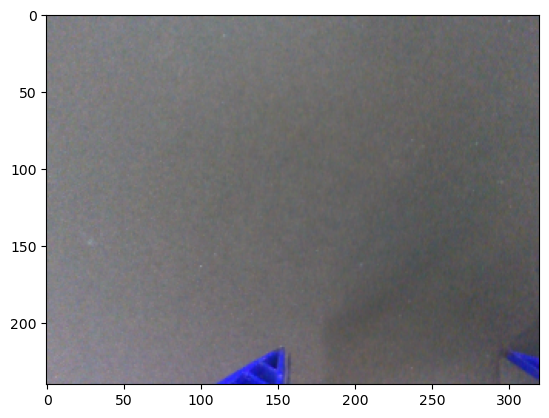

In [26]:
img=imgs[0].transpose(1,2, 0)
plt.imshow(img)

In [120]:
# 8) Visualize final real EEF poses vs. safe set
all_poses_7d = np.array(all_poses_7d)
all_inside_flags = np.array(all_inside_flags, dtype=bool)
if len(all_poses_7d) > 0:
    visualize_policy_predictions(
        safe_set,
        predicted_poses_7d=all_poses_7d,
        inside_flags=all_inside_flags,
        title="Policy vs. Safe Set (Real Joints after Action)"
    )
else:
    print("No EEF poses to visualize.")

In [ ]:
mg = remove_background_from_image(img,bg_interface=bg_interface)# # reset robot
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions)
set_gripper(open=True)

JOINT_POSITION


In [ ]:
# # reset robot
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions)
set_gripper(open=True)
all_poses_7d = []
all_inside_flags=[]

def push_pose_outside_safe_set_7d(pose_7d, hull_equations, margin=1e-3, tol=1e-8):
    pose_6d = pose7d_to_6d(pose_7d)
    inside, distances = is_pose_in_safe_set_6d(pose_6d, hull_equations, tol)
    if not inside:
        return pose_7d
    i_max = np.argmax(distances)
    d_max = distances[i_max]
    A_i = hull_equations[i_max, :-1]
    norm_A = np.linalg.norm(A_i)
    shift = ((tol - d_max) + margin) * (A_i / norm_A)
    pose_6d_out = pose_6d + shift
    new_pos = pose_6d_out[:3]
    new_rotvec = pose_6d_out[3:]
    new_quat = R.from_rotvec(new_rotvec).as_quat()
    new_pose_7d = np.hstack([new_pos, new_quat])
    return new_pose_7d


def push_robot_outside_loop(robot_interface, hull_equations, max_tries=10, margin=1e-6, tol=1e-12):
    """
    Repeatedly check if robot is inside safe set, if so push it out
    and command the new pose, up to `max_tries`.
    """
    tries = 0
    while tries < max_tries:
        # read real joints
        js_real = robot_interface.last_q
        if js_real is None:
            print("No joint angles read, skip attempt.")
            time.sleep(0.05)
            tries += 1
            continue

        # convert to 7D
        eef_pose_7d = joint_angles_to_end_effector_pose(js_real)
        pose_6d = pose7d_to_6d(eef_pose_7d)
        inside, distances = is_pose_in_safe_set_6d(pose_6d, hull_equations, tol)
        # 7) Collect for final visualization
        all_poses_7d.append(eef_pose_7d)
        all_inside_flags.append(inside)
        if not inside:
            print("Already outside the safe set!")
            break

        # push it
        pushed_pose_7d = push_pose_outside_safe_set_7d(eef_pose_7d, hull_equations, margin, tol)
        print(f"Push attempt {tries}: new pose => {pushed_pose_7d}")

        # command the new pose
        robot_interface.control(
            controller_type="OSC_POSE",  # or your controller
            action=pushed_pose_7d,
            controller_cfg=controller_cfg,
        )

        time.sleep(0.5)
        tries += 1

    if tries >= max_tries:
        print("Reached max tries; might still be inside or can't push further.")


###############################################################################
# 3) Example integrated with your policy rollout: push after 4 steps
###############################################################################
# def main_policy_rollout_with_push(robot_interface, hull_equations, policy, max_steps=10):
policy.reset()

for step in range(50):
    # 1) Acquire user input, or do something else
    action, grasp = input2action(device=spacemouse, controller_type=controller_type)
    if action is None:
        break
    if len(robot_interface._state_buffer) == 0:
        continue

    # 2) Predict actions (whatever your policy returns)
    obs_dict = get_current_obs(robot_interface)
    obs = framestacker.add_new_obs(obs_dict)
    action_pred = predict_action(obs)  # shape (N,7) or (N,6), etc.
    print(f"Step {step}:")

    # 3) Send some subset of those actions to the robot
    for i, single_cmd in enumerate(action_pred[:6]):  # e.g. first 6
        print(f"Sending action {i} => {single_cmd}")
        robot_interface.control(
            controller_type=controller_type,
            action=single_cmd,
            controller_cfg=controller_cfg,
        )
        time.sleep(0.1)
    
    # convert to 7D
    js_real = robot_interface.last_q
    if js_real is None:
        print("No joint angles read, skip attempt.")
        time.sleep(0.05)
        # tries += 1
        continue
    eef_pose_7d = joint_angles_to_end_effector_pose(js_real)
    pose_6d = pose7d_to_6d(eef_pose_7d)
    inside, distances = is_pose_in_safe_set_6d(pose_6d, hull_equations, 1e-1)
    
    # 7) Collect for final visualization
    all_poses_7d.append(eef_pose_7d)
    all_inside_flags.append(inside)

    # 4) At step == 4, do the "push outside" loop
    if step == 6:
        print("Now pushing the robot outside the safe set!")
        push_robot_outside_loop(robot_interface, hull_equations, max_tries=10, margin=1e-3)
        # After the push loop, we continue normal steps
        # Or if you prefer, you could break out entirely.

robot_interface.close()

JOINT_POSITION


KeyboardInterrupt: 

In [ ]:
# 8) Visualize final real EEF poses vs. safe set
all_poses_7d = np.array(all_poses_7d)
all_inside_flags = np.array(all_inside_flags, dtype=bool)
if len(all_poses_7d) > 0:
    visualize_policy_predictions(
        safe_set,
        predicted_poses_7d=all_poses_7d,
        inside_flags=all_inside_flags,
        title="Policy vs. Safe Set (Real Joints after Action)"
    )
else:
    print("No EEF poses to visualize.")

Background Removed Safeset Testing

In [15]:
import time
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import ConvexHull
from scipy.spatial.transform import Rotation as R


import os
import torch
from PIL import Image
import cv2
from carvekit.api.high import HiInterface

def remove_background_from_image(input_image, temp_filename="temp_bg.png", device=None,bg_interface=None):
    """
    Removes the background from the provided image using HiInterface and composites it on a white background.
    
    Parameters:
        input_image (PIL.Image.Image or np.ndarray): The input image. If provided as a NumPy array (BGR),
            it will be converted to a PIL image.
        temp_filename (str): Temporary filename to save the image.
        device (str): Device to use ('cuda' or 'cpu'). If None, it selects automatically.
    
    Returns:
        PIL.Image.Image: The background removed image (composited on a white background).
    """
    
    
    # Convert input_image to PIL Image if necessary.
    if not isinstance(input_image, Image.Image):
        # Assume input image is in BGR (OpenCV format); convert to RGB and then to PIL.
        input_image = Image.fromarray(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    
    # Save the input image temporarily.
    input_image.save(temp_filename)
    
    
    
    # Process the image. HiInterface expects a list of file paths.
    processed_image = bg_interface([temp_filename])[0]
    
    # Optionally, remove the temporary file.
    os.remove(temp_filename)
    
    return processed_image
###############################################################################
# 1) (Unchanged) Forward Kinematics & Safe-Set Utilities
###############################################################################
def dh_transform(a, alpha, d, theta):
    return np.array([
        [ np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha),  a*np.cos(theta)],
        [ np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha),  a*np.sin(theta)],
        [ 0,              np.sin(alpha),                np.cos(alpha),                d              ],
        [ 0,              0,                            0,                            1              ]
    ], dtype=float)


def franka_forward_kinematics(joint_angles):
    """
    Returns a 4x4 transform from the panda base to the 'panda_hand' link.
    """
    q1, q2, q3, q4, q5, q6, q7 = joint_angles
    
    # DH transforms up to the flange (link8 in the URDF).
    T1 = dh_transform(a=0,       alpha=0,         d=0.333,   theta=q1)
    T2 = dh_transform(a=0,       alpha=-np.pi/2,  d=0,       theta=q2)
    T3 = dh_transform(a=0,       alpha=np.pi/2,   d=0.316,   theta=q3)
    T4 = dh_transform(a=0.0825,  alpha=np.pi/2,   d=0,       theta=q4)
    T5 = dh_transform(a=-0.0825, alpha=-np.pi/2,  d=0.384,   theta=q5)
    T6 = dh_transform(a=0,       alpha=np.pi/2,   d=0,       theta=q6)
    T7 = dh_transform(a=0.088,   alpha=np.pi/2,   d=0,       theta=q7)
    
    # Flange offset (link8).
    T_flange = dh_transform(a=0, alpha=0, d=0.107, theta=0)
    
    # Extra rotation from flange -> panda_hand (about Z by -π/4).
    Rz_neg_45 = dh_transform(a=0, alpha=0, d=0, theta=-np.pi/4)

    T_panda_hand = T1 @ T2 @ T3 @ T4 @ T5 @ T6 @ T7 @ T_flange @ Rz_neg_45
    return T_panda_hand

def joint_angles_to_end_effector_pose(joint_angles):
    """
    Convert 7 Franka joint angles -> [x, y, z, qx, qy, qz, qw].
    (Exactly the same as in your safe-set code.)
    """
    T = franka_forward_kinematics(joint_angles)
    x, y, z = T[0, 3], T[1, 3], T[2, 3]
    rot_mat = T[:3, :3]
    quat = R.from_matrix(rot_mat).as_quat()  # [qx, qy, qz, qw]
    return np.array([x, y, z, quat[0], quat[1], quat[2], quat[3]], dtype=float)

def normalize_quaternion(q):
    norm = np.linalg.norm(q)
    return q / norm if norm > 1e-6 else np.array([0, 0, 0, 1])

def pose7d_to_6d(pose7d):
    """
    Converts a 7D pose (position + quaternion) into a minimal 6D representation.
    
    Parameters:
        pose7d (array-like): A 7D pose given as [x, y, z, qx, qy, qz, qw].
    
    Returns:
        np.ndarray: A 6D pose as [x, y, z, rx, ry, rz], where (rx, ry, rz) is the rotation vector.
    """
    pos = np.array(pose7d[:3])
    quat = np.array(pose7d[3:7])
    norm = np.linalg.norm(quat)
    if norm < 1e-6:
        quat = np.array([0, 0, 0, 1])
    else:
        quat = quat / norm
    rotvec = R.from_quat(quat).as_rotvec()
    return np.hstack([pos, rotvec])

def is_pose_in_safe_set_6d(query_6d, hull_equations, tol=1e-8):
    """
    Checks if the query 6D pose is inside the safe set.
    
    Since the safe set was built using only the 3D positions of candidate poses,
    this function extracts the position part (first three coordinates) from the
    query 6D pose and checks whether that point lies within the convex hull.
    
    Parameters:
        query_6d (array-like): The query pose in 6D minimal representation,
                               e.g., [x, y, z, rx, ry, rz].
        hull_equations (np.ndarray): Convex hull equations computed from the safe set
                                     (constructed from 3D positions, shape (m, 4)).
        tol (float): Tolerance for the hull check.
    
    Returns:
        inside (bool): True if the 3D position of the query pose is inside the safe set.
        distances (np.ndarray): The signed distances from the query point to each hull facet.
    """
    # Extract the position part (first three coordinates)
    query_pos = np.array(query_6d[:3])
    
    # hull_equations is expected to be of shape (m, 4): [A1, A2, A3, b]
    A = hull_equations[:, :-1]  # shape (m, 3)
    b = hull_equations[:, -1]   # shape (m,)
    
    # Compute the distance of the query point from each facet of the hull.
    norms = np.linalg.norm(A, axis=1)
    distances = (A.dot(query_pos) + b) / norms
    
    inside = np.all(distances <= tol)
    return inside, distances


def load_safe_set(file_path="safe_set_6d.npz"):
    data = np.load(file_path)
    return data["safe_set"], data["hull_equations"], data["hull_vertices"]


###############################################################################
# 2) Visualization (optional, unchanged from your snippet)
###############################################################################
def visualize_policy_predictions(safe_set, predicted_poses_7d, inside_flags, title="Policy Predictions vs. Safe Set"):
    hull_3d = ConvexHull(safe_set[:, :3])
    fig = go.Figure()
    fig.add_trace(go.Mesh3d(
        x=safe_set[:, 0],
        y=safe_set[:, 1],
        z=safe_set[:, 2],
        i=hull_3d.simplices[:, 0],
        j=hull_3d.simplices[:, 1],
        k=hull_3d.simplices[:, 2],
        opacity=0.3,
        color='lightblue',
        name='Safe Set Hull'
    ))
    predicted_positions = predicted_poses_7d[:, :3]
    colors = ["green" if flag else "red" for flag in inside_flags]
    fig.add_trace(go.Scatter3d(
        x=predicted_positions[:, 0],
        y=predicted_positions[:, 1],
        z=predicted_positions[:, 2],
        mode='markers+lines',
        marker=dict(size=5, color=colors),
        line=dict(color='gray', width=2),
        name='EEF Poses (Real Joints)'
    ))
    fig.update_layout(
        title=title,
        scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z")
    )
    fig.show()


def push_pose_outside_safe_set_7d(pose_7d, hull_equations, margin=1e-3, tol=1e-8):
    """
    If pose_7d is inside the safe set, push it slightly outside along the facet
    with the largest distance. This ensures the resulting pose is outside by
    at least 'margin'.

    pose_7d: [x,y,z, qx,qy,qz,qw]
    hull_equations: from your .npz file => hull_equations
    margin: how far beyond the hull to push
    tol: tolerance to treat as "inside"

    Returns:
      new_pose_7d: The pose (7D) guaranteed to be outside the safe set.
    """
    # 1) Convert to 6D (pos + rotation vector)
    pose_6d = pose7d_to_6d(pose_7d)
    inside, distances = is_pose_in_safe_set_6d(pose_6d, hull_equations, tol)
    if not inside:
        # Already outside => return as-is
        return pose_7d

    # 2) Find the facet with the maximum distance
    #    Typically, distances for an inside point are <= 0 or negative, but we pick
    #    the largest anyway. We'll push along that normal.
    i_max = np.argmax(distances)
    d_max = distances[i_max]
    A_i = hull_equations[i_max, :-1]   # normal vector
    norm_A = np.linalg.norm(A_i)

    # 3) Compute shift => we move (tol - d_max + margin) along the normal
    #    so that the new point is just outside by 'margin'.
    shift_6d = ((tol - d_max) + margin) * (A_i / norm_A)
    pose_6d_out = pose_6d + shift_6d

    # 4) Convert back to 7D => new position + orientation
    new_pos = pose_6d_out[:3]
    new_rotvec = pose_6d_out[3:]
    new_quat = R.from_rotvec(new_rotvec).as_quat()
    new_pose_7d = np.hstack([new_pos, new_quat])
    return new_pose_7d

# safe_set_file="/home/franka_deoxys/safe_set_6d_fv_rg.npz"
safe_set_file = '/home/franka_deoxys/riad/safe_set_6d_fv_rg.npz'
safe_set, hull_equations, _ = load_safe_set(safe_set_file)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Create the background removal interface.
bg_interface = HiInterface(
    object_type="hairs-like",
    batch_size_seg=5,
    batch_size_matting=1,
    device=device,
    seg_mask_size=320,
    matting_mask_size=1024,
    trimap_prob_threshold=231,
    trimap_dilation=30,
    trimap_erosion_iters=5,
    fp16=False
)

In [46]:
# # reset robot
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions)
set_gripper(open=True)
policy.reset()

JOINT_POSITION


In [16]:
# # reset robot
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions)
set_gripper(open=True)
policy.reset()

images = []
all_poses_7d = []
all_inside_flags = []

for _ in range(50):
    # 1) Acquire user input
    action, grasp = input2action(device=spacemouse, controller_type=controller_type)
    if action is None:
        break
    if len(robot_interface._state_buffer) == 0:
        continue

    # 2) Get observation
    obs_dict = get_current_obs(robot_interface)
    img = obs_dict['eye_in_hand_rgb_bg_removed']
    images.append(img)
    obs = framestacker.add_new_obs(obs_dict)

    # 3) Policy predicts an action (whatever format: delta pose, EEF pose, etc.)
    #    We'll send it to the robot
    action_pred = predict_action(obs)  # shape is up to your policy
    # print("Raw policy prediction:", action_pred)

    

    # 4) Let's say we control the robot with the first 4 predicted actions
    for i, single_cmd in enumerate(action_pred[:4]):
        print(f"Sending to robot: action {i} =>", single_cmd)
        robot_interface.control(
            controller_type=controller_type,
            action=single_cmd,
            controller_cfg=controller_cfg,
        )

        # (Optional) short delay for the robot to move
        time.sleep(0.05)

        # 5) Now read the *actual* real joint angles from the robot
        #    e.g. shape (7,) => [q1, q2, q3, q4, q5, q6, q7]
        js_real = robot_interface.last_q  
        if js_real is None:
            print("No joint angles read. Skipping.")
            continue

        # 6) Convert those real joints => 7D EEF pose => 6D => safe-set check
        eef_pose_7d = joint_angles_to_end_effector_pose(js_real)  # shape (7,)
        eef_pose_6d = pose7d_to_6d(eef_pose_7d)
        inside, distances = is_pose_in_safe_set_6d(eef_pose_6d, hull_equations, tol=1e-1)

        # print(f"   => Real Joints {js_real}, EEF pose {eef_pose_7d}")
        print(f"   => inside={inside}, distances={distances}")

        # 7) Collect for final visualization
        all_poses_7d.append(eef_pose_7d)
        all_inside_flags.append(inside)

robot_interface.close()

JOINT_POSITION
from controller:  [0. 0. 0.] [0. 0. 0.]
Sending to robot: action 0 => [ 0.346  0.002  0.011 -0.001  0.019  0.003 -1.   ]
   => inside=True, distances=[-1.229 -1.122 -1.241 ... -0.997 -1.01  -0.91 ]
Sending to robot: action 1 => [ 0.364  0.003  0.023 -0.006  0.019 -0.003 -1.   ]
   => inside=True, distances=[-1.23  -1.123 -1.242 ... -0.997 -1.01  -0.91 ]
Sending to robot: action 2 => [ 0.373  0.004  0.012 -0.006  0.011 -0.002 -1.   ]
   => inside=True, distances=[-1.231 -1.126 -1.243 ... -0.994 -1.007 -0.907]
Sending to robot: action 3 => [ 0.394  0.004  0.019 -0.003  0.01  -0.001 -1.   ]
   => inside=True, distances=[-1.233 -1.131 -1.245 ... -0.989 -1.003 -0.903]
from controller:  [0. 0. 0.] [0. 0. 0.]
Sending to robot: action 0 => [ 0.346  0.021  0.039  0.005  0.018  0.003 -1.   ]
   => inside=True, distances=[-1.239 -1.153 -1.249 ... -0.958 -0.973 -0.876]
Sending to robot: action 1 => [ 0.333  0.013  0.027  0.005  0.014  0.001 -0.997]
   => inside=True, distances=[-1.2

KeyboardInterrupt: 

In [17]:
# 8) Visualize final real EEF poses vs. safe set
all_poses_7d = np.array(all_poses_7d)
all_inside_flags = np.array(all_inside_flags, dtype=bool)
if len(all_poses_7d) > 0:
    visualize_policy_predictions(
        safe_set,
        predicted_poses_7d=all_poses_7d,
        inside_flags=all_inside_flags,
        title="Policy vs. Safe Set (Real Joints after Action)"
    )
else:
    print("No EEF poses to visualize.")

In [31]:
import time
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import ConvexHull
from scipy.spatial.transform import Rotation as R
import os
import torch
from PIL import Image
import cv2
from carvekit.api.high import HiInterface

###############################################################################
# 1) Background Removal Utility
###############################################################################
def remove_background_from_image(input_image, temp_filename="temp_bg.png", device=None, bg_interface=None):
    """
    Removes the background from the provided image using HiInterface and composites it on a white background.
    """
    if not isinstance(input_image, Image.Image):
        input_image = Image.fromarray(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    input_image.save(temp_filename)
    processed_image = bg_interface([temp_filename])[0]
    os.remove(temp_filename)
    return processed_image

###############################################################################
# 2) Forward Kinematics & Safe-Set Utilities
###############################################################################
def dh_transform(a, alpha, d, theta):
    return np.array([
        [ np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha),  a*np.cos(theta)],
        [ np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha),  a*np.sin(theta)],
        [ 0,              np.sin(alpha),                np.cos(alpha),                d              ],
        [ 0,              0,                            0,                            1              ]
    ], dtype=float)

def franka_forward_kinematics(joint_angles):
    q1, q2, q3, q4, q5, q6, q7 = joint_angles
    T1 = dh_transform(a=0,       alpha=0,         d=0.333,   theta=q1)
    T2 = dh_transform(a=0,       alpha=-np.pi/2,  d=0,       theta=q2)
    T3 = dh_transform(a=0,       alpha=np.pi/2,   d=0.316,   theta=q3)
    T4 = dh_transform(a=0.0825,  alpha=np.pi/2,   d=0,       theta=q4)
    T5 = dh_transform(a=-0.0825, alpha=-np.pi/2,  d=0.384,   theta=q5)
    T6 = dh_transform(a=0,       alpha=np.pi/2,   d=0,       theta=q6)
    T7 = dh_transform(a=0.088,   alpha=np.pi/2,   d=0,       theta=q7)
    T_flange = dh_transform(a=0, alpha=0, d=0.107, theta=0)
    Rz_neg_45 = dh_transform(a=0, alpha=0, d=0, theta=-np.pi/4)
    T_panda_hand = T1 @ T2 @ T3 @ T4 @ T5 @ T6 @ T7 @ T_flange @ Rz_neg_45
    return T_panda_hand

def joint_angles_to_end_effector_pose(joint_angles):
    T = franka_forward_kinematics(joint_angles)
    x, y, z = T[0, 3], T[1, 3], T[2, 3]
    rot_mat = T[:3, :3]
    quat = R.from_matrix(rot_mat).as_quat()  # [qx, qy, qz, qw]
    return np.array([x, y, z, quat[0], quat[1], quat[2], quat[3]], dtype=float)

def normalize_quaternion(q):
    norm = np.linalg.norm(q)
    return q / norm if norm > 1e-6 else np.array([0, 0, 0, 1])

def pose7d_to_6d(pose7d):
    """
    Converts a 7D pose (position + quaternion) into a minimal 6D representation:
      [x, y, z, rx, ry, rz], where (rx, ry, rz) is the rotation vector.
    """
    pos = np.array(pose7d[:3])
    quat = np.array(pose7d[3:7])
    norm = np.linalg.norm(quat)
    if norm < 1e-6:
        quat = np.array([0, 0, 0, 1])
    else:
        quat = quat / norm
    rotvec = R.from_quat(quat).as_rotvec()
    return np.hstack([pos, rotvec])

def is_pose_in_safe_set_6d(query_6d, hull_equations, tol=1e-8):
    query_pos = np.array(query_6d[:3])
    A = hull_equations[:, :-1]
    b = hull_equations[:, -1]
    norms = np.linalg.norm(A, axis=1)
    distances = (A.dot(query_pos) + b) / norms
    inside = np.all(distances <= tol)
    return inside, distances

def load_safe_set(file_path="safe_set_6d.npz"):
    data = np.load(file_path)
    return data["safe_set"], data["hull_equations"], data["hull_vertices"]

###############################################################################
# 3) Visualization Utility
###############################################################################
def visualize_policy_predictions(safe_set, predicted_poses_7d, inside_flags, title="Policy Predictions vs. Safe Set"):
    hull_3d = ConvexHull(safe_set[:, :3])
    fig = go.Figure()
    fig.add_trace(go.Mesh3d(
        x=safe_set[:, 0],
        y=safe_set[:, 1],
        z=safe_set[:, 2],
        i=hull_3d.simplices[:, 0],
        j=hull_3d.simplices[:, 1],
        k=hull_3d.simplices[:, 2],
        opacity=0.3,
        color='lightblue',
        name='Safe Set Hull'
    ))
    predicted_positions = predicted_poses_7d[:, :3]
    colors = ["green" if flag else "red" for flag in inside_flags]
    fig.add_trace(go.Scatter3d(
        x=predicted_positions[:, 0],
        y=predicted_positions[:, 1],
        z=predicted_positions[:, 2],
        mode='markers+lines',
        marker=dict(size=5, color=colors),
        line=dict(color='gray', width=2),
        name='EEF Poses (Real Joints)'
    ))
    fig.update_layout(
        title=title,
        scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z")
    )
    fig.show()

###############################################################################
# 4) Experiment 1: Gradual Gentle Push Functions (Full 6D)
###############################################################################
def gradual_push_pose_outside_safe_set_7d(pose_7d, hull_equations, gentle_push=1e-4, near_threshold=5e-3, tol=1e-1, margin=1e-6):
    """
    Gradually push the full 6D pose (position + orientation) by a very small amount along the most limiting facet,
    but only if the command is near the safe-set boundary.
    
    Returns the new 7D pose.
    """
    pose_6d = pose7d_to_6d(pose_7d)
    inside, distances = is_pose_in_safe_set_6d(pose_6d, hull_equations, tol)
    if not inside:
        # Already outside; no push needed.
        return pose_7d

    # Identify the facet that is closest to violation.
    i_max = np.argmax(distances)
    d_max = distances[i_max]
    
    # Only apply the gentle push if the gap (tol - d_max) is smaller than near_threshold.
    if (tol - d_max) < near_threshold:
        # Calculate the minimal shift needed (plus a small margin) to cross the boundary.
        required_shift = (tol - d_max + margin)
        shift_magnitude = min(required_shift, gentle_push)
        A_i = hull_equations[i_max, :-1]
        norm_A = np.linalg.norm(A_i)
        shift = shift_magnitude * (A_i / norm_A)
        pose_6d_out = pose_6d + shift
        new_pos = pose_6d_out[:3]
        new_rotvec = pose_6d_out[3:]
        new_quat = R.from_rotvec(new_rotvec).as_quat()
        new_pose_7d = np.hstack([new_pos, new_quat])
        return new_pose_7d
    else:
        return pose_7d

def safety_gradual_push_filter(pose_7d, hull_equations, gentle_push=1e-4, near_threshold=5e-3, tol=1e-1, margin=1e-6):
    """
    For Experiment 1:
      - If the 6D command pose is inside but near the safe-set boundary, applies a minimal gentle push.
      - Otherwise, returns the command unchanged.
      
    Returns:
        new_pose (np.ndarray): The (possibly) modified command.
        mode (str): "pushed" if a push was applied, otherwise "nominal".
    """
    new_pose = gradual_push_pose_outside_safe_set_7d(pose_7d, hull_equations, gentle_push, near_threshold, tol, margin)
    mode = "pushed" if not np.allclose(new_pose, pose_7d) else "nominal"
    return new_pose, mode

###############################################################################
# 5) Experiment 2: Push + Nagumo Correction Functions (Full 6D)
###############################################################################
def push_pose_outside_safe_set_7d(pose_7d, hull_equations, margin=1e-3, tol=1e-8):
    """
    If pose_7d is inside the safe set, push it along the most limiting facet so that
    the new command is outside by at least 'margin'. This is computed in the full 6D space.
    """
    pose_6d = pose7d_to_6d(pose_7d)
    inside, distances = is_pose_in_safe_set_6d(pose_6d, hull_equations, tol)
    if not inside:
        return pose_7d
    i_max = np.argmax(distances)
    d_max = distances[i_max]
    A_i = hull_equations[i_max, :-1]
    norm_A = np.linalg.norm(A_i)
    shift_6d = ((tol - d_max) + margin) * (A_i / norm_A)
    pose_6d_out = pose_6d + shift_6d
    new_pos = pose_6d_out[:3]
    new_rotvec = pose_6d_out[3:]
    new_quat = R.from_rotvec(new_rotvec).as_quat()
    new_pose_7d = np.hstack([new_pos, new_quat])
    return new_pose_7d

def nagumo_correction_pose_7d(pose_7d, hull_equations, margin=1e-3, tol=1e-1):
    """
    Computes a minimal correction action for the full 6D pose (position + orientation)
    to bring an out-of-set command back inside the safe set. The correction is computed 
    in the full 6D space based on the maximum violation.
    """
    pose_6d = pose7d_to_6d(pose_7d)
    A = hull_equations[:, :-1]  # shape (m, 6)
    b = hull_equations[:, -1]   # shape (m,)
    norms = np.linalg.norm(A, axis=1)
    distances = (A.dot(pose_6d) + b) / norms
    violations = distances - tol
    if not np.any(violations > 0):
        return pose_7d
    i_max = np.argmax(violations)
    violation_value = violations[i_max]
    A_i = A[i_max]
    norm_A = norms[i_max]
    shift = (violation_value + margin) * (A_i / norm_A)
    pose_6d_corrected = pose_6d - shift
    new_pos = pose_6d_corrected[:3]
    new_rotvec = pose_6d_corrected[3:]
    new_quat = R.from_rotvec(new_rotvec).as_quat()
    new_pose_7d = np.hstack([new_pos, new_quat])
    return new_pose_7d

def safety_switching_filter(pose_7d, hull_equations, margin=1e-3, tol=1e-1, boundary_threshold=5e-3):
    """
    For Experiment 2:
      - If the full 6D command is inside and far from the boundary, it is unchanged.
      - If inside but near the boundary, a full push is applied.
      - If outside, a Nagumo-based correction is computed.
    """
    pose_6d = pose7d_to_6d(pose_7d)
    inside, distances = is_pose_in_safe_set_6d(pose_6d, hull_equations, tol)
    if inside:
        if np.any(np.abs(distances - tol) < boundary_threshold):
            pushed_pose = push_pose_outside_safe_set_7d(pose_7d, hull_equations, margin, tol)
            return pushed_pose, "pushed"
        else:
            return pose_7d, "nominal"
    else:
        correction_pose = nagumo_correction_pose_7d(pose_7d, hull_equations, margin, tol)
        return correction_pose, "corrected"

###############################################################################
# 6) Main Execution and Control Loop
###############################################################################
# Load safe set from file (update path as needed)
safe_set_file = '/home/franka_deoxys/riad/safe_set_6d_fv_rg.npz'
safe_set, hull_equations, _ = load_safe_set(safe_set_file)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
bg_interface = HiInterface(
    object_type="hairs-like",
    batch_size_seg=5,
    batch_size_matting=1,
    device=device,
    seg_mask_size=320,
    matting_mask_size=1024,
    trimap_prob_threshold=231,
    trimap_dilation=30,
    trimap_erosion_iters=5,
    fp16=False
)

In [144]:
import time
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import ConvexHull
from scipy.spatial.transform import Rotation as R
import os
import torch
from PIL import Image
import cv2
from carvekit.api.high import HiInterface

###############################################################################
# 1) Background Removal Utility (unchanged)
###############################################################################
def remove_background_from_image(input_image, temp_filename="temp_bg.png", device=None, bg_interface=None):
    if not isinstance(input_image, Image.Image):
        input_image = Image.fromarray(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    input_image.save(temp_filename)
    processed_image = bg_interface([temp_filename])[0]
    os.remove(temp_filename)
    return processed_image

###############################################################################
# 2) Forward Kinematics & Safe-Set Utilities (unchanged except for comments)
###############################################################################
def dh_transform(a, alpha, d, theta):
    return np.array([
        [ np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha),  a*np.cos(theta)],
        [ np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha),  a*np.sin(theta)],
        [ 0,              np.sin(alpha),                np.cos(alpha),                d              ],
        [ 0,              0,                            0,                            1              ]
    ], dtype=float)

def franka_forward_kinematics(joint_angles):
    q1, q2, q3, q4, q5, q6, q7 = joint_angles
    T1 = dh_transform(a=0,       alpha=0,         d=0.333,   theta=q1)
    T2 = dh_transform(a=0,       alpha=-np.pi/2,  d=0,       theta=q2)
    T3 = dh_transform(a=0,       alpha=np.pi/2,   d=0.316,   theta=q3)
    T4 = dh_transform(a=0.0825,  alpha=np.pi/2,   d=0,       theta=q4)
    T5 = dh_transform(a=-0.0825, alpha=-np.pi/2,  d=0.384,   theta=q5)
    T6 = dh_transform(a=0,       alpha=np.pi/2,   d=0,       theta=q6)
    T7 = dh_transform(a=0.088,   alpha=np.pi/2,   d=0,       theta=q7)
    T_flange = dh_transform(a=0, alpha=0, d=0.107, theta=0)
    Rz_neg_45 = dh_transform(a=0, alpha=0, d=0, theta=-np.pi/4)
    T_panda_hand = T1 @ T2 @ T3 @ T4 @ T5 @ T6 @ T7 @ T_flange @ Rz_neg_45
    return T_panda_hand

def joint_angles_to_end_effector_pose(joint_angles):
    T = franka_forward_kinematics(joint_angles)
    x, y, z = T[0, 3], T[1, 3], T[2, 3]
    rot_mat = T[:3, :3]
    quat = R.from_matrix(rot_mat).as_quat()  # [qx, qy, qz, qw]
    return np.array([x, y, z, quat[0], quat[1], quat[2], quat[3]], dtype=float)

def normalize_quaternion(q):
    norm = np.linalg.norm(q)
    return q / norm if norm > 1e-6 else np.array([0, 0, 0, 1])

def pose7d_to_6d(pose7d):
    pos = np.array(pose7d[:3])
    quat = np.array(pose7d[3:7])
    norm = np.linalg.norm(quat)
    if norm < 1e-6:
        quat = np.array([0, 0, 0, 1])
    else:
        quat = quat / norm
    rotvec = R.from_quat(quat).as_rotvec()
    return np.hstack([pos, rotvec])

# DO NOT CHANGE THIS FUNCTION
# def is_pose_in_safe_set_6d(query_6d, hull_equations, tol=1e-8):
#     query_pos = np.array(query_6d[:3])
#     A = hull_equations[:, :-1]
#     b = hull_equations[:, -1]
#     norms = np.linalg.norm(A, axis=1)
#     distances = (A.dot(query_pos) + b) / norms
#     inside = np.all(distances <= tol)
#     return inside, distances

def is_pose_in_safe_set_6d(query_6d, hull_equations, tol=1e-8):
    """
    Checks if a 6D pose [x, y, z, rx, ry, rz] is inside the safe set,
    given the convex hull equations computed in 6D.

    Parameters:
        query_6d (array-like): 6D pose, e.g., [x, y, z, rx, ry, rz].
        hull_equations (np.ndarray): Array of shape (m,7) where each row is [A1,...,A6, b].
        tol (float): Tolerance for determining inclusion.

    Returns:
        inside (bool): True if the pose satisfies all inequalities.
        distances (np.ndarray): The signed distances from the query to each facet.
    """
    query_point = np.array(query_6d)  # Full 6D vector.
    A = hull_equations[:, :-1]       # (m, 6) matrix of facet normals.
    b = hull_equations[:, -1]        # (m,) offsets.
    norms = np.linalg.norm(A, axis=1)
    distances = (A.dot(query_point) + b) / norms
    inside = np.all(distances <= tol)
    return inside, distances



def load_safe_set(file_path="safe_set_6d.npz"):
    data = np.load(file_path)
    return data["safe_set"], data["hull_equations"], data["hull_vertices"]

###############################################################################
# 3) Visualization Utility (unchanged)
###############################################################################
def visualize_policy_predictions(safe_set, predicted_poses_7d, inside_flags, title="Policy Predictions vs. Safe Set"):
    hull_3d = ConvexHull(safe_set[:, :3])
    fig = go.Figure()
    fig.add_trace(go.Mesh3d(
        x=safe_set[:, 0],
        y=safe_set[:, 1],
        z=safe_set[:, 2],
        i=hull_3d.simplices[:, 0],
        j=hull_3d.simplices[:, 1],
        k=hull_3d.simplices[:, 2],
        opacity=0.3,
        color='lightblue',
        name='Safe Set Hull'
    ))
    predicted_positions = predicted_poses_7d[:, :3]
    colors = ["green" if flag else "red" for flag in inside_flags]
    fig.add_trace(go.Scatter3d(
        x=predicted_positions[:, 0],
        y=predicted_positions[:, 1],
        z=predicted_positions[:, 2],
        mode='markers+lines',
        marker=dict(size=5, color=colors),
        line=dict(color='gray', width=2),
        name='EEF Poses (Real Joints)'
    ))
    fig.update_layout(
        title=title,
        scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z")
    )
    fig.show()

# def iterative_push_delta_until_outside(current_pose, delta_cmd, hull_equations,
#                                        robot_interface, controller_type, controller_cfg,
#                                        tol=1e-1, margin=1e-3, max_iter=50):
#     """
#     Given the current absolute pose (7D) and a predicted delta command (7D),
#     this function executes a push in full 6D until the measured absolute pose is outside
#     the safe set. It operates by converting the inputs to 6D (position + rotation vector),
#     updating the delta command iteratively, and then converting back to 7D.
    
#     Parameters:
#         current_pose: Current absolute pose (7D: [x, y, z, qx, qy, qz, qw]).
#         delta_cmd: Predicted delta command (7D) – the command to add to current_pose.
#         hull_equations: Convex hull equations in 6D (each row: [A1,...,A6, b]).
#         robot_interface: The robot interface object used for sending control commands.
#         controller_type: Controller type (passed to robot_interface.control).
#         controller_cfg: Controller configuration.
#         tol: Tolerance for safe-set inclusion (e.g. 1e-1). A point is considered outside if any
#              facet has a positive signed distance when tol=0.0.
#         margin: Additional margin to ensure the command crosses the boundary.
#         max_iter: Maximum iterations.
    
#     Returns:
#         new_delta_7d: The updated delta command (7D) computed as (new_abs_pose - current_pose).
#         push_direction: The normalized overall push direction (6D) applied (if any), or None if no push was needed.
#         final_abs_pose: The final absolute pose (7D) after push.
#     """
#     # Convert current_pose (7D) to 6D.
#     current_pose_6d = pose7d_to_6d(current_pose)
    
#     # Convert delta_cmd (7D) to 6D.
#     delta_translation = delta_cmd[:3]
#     delimgta_rotvec = R.from_quat(delta_cmd[3:7]).as_rotvec()
#     delta_cmd_6d = np.hstack([delta_translation, delta_rotvec])
    
#     # Start with the initial 6D delta.
#     new_delta_6d = np.copy(delta_cmd_6d)
#     total_shift = np.zeros(6)
    
#     for _ in range(max_iter):
#         # Compute the predicted absolute 6D pose.
#         predicted_abs_6d = current_pose_6d + new_delta_6d
        
#         # Convert new_delta_6d back to 7D command for execution.
#         new_delta_translation = new_delta_6d[:3]
#         new_delta_quat = R.from_rotvec(new_delta_6d[3:]).as_quat()
#         new_delta_7d = np.hstack([new_delta_translation, new_delta_quat])
        
#         # Send the delta command.
#         robot_interface.control(controller_type=controller_type,
#                                   action=new_delta_7d,
#                                   controller_cfg=controller_cfg)
#         time.sleep(0.05)
        
#         # Read the measured state.
#         js = robot_interface.last_q
#         if js is None:
#             continue  # Try again if no feedback.
#         measured_pose = joint_angles_to_end_effector_pose(js)
#         measured_pose_6d = pose7d_to_6d(measured_pose)
        
#         # Check if the measured 6D pose is outside the safe set.
#         inside, distances = is_pose_in_safe_set_6d(measured_pose_6d, hull_equations, tol)
#         print("Push iteration: measured safe-set check: inside =", inside, "distances =", distances)
#         if not inside:
#             break
        
#         # Compute additional required shift in 6D.
#         i_max = np.argmax(distances)
#         d_max = distances[i_max]
#         A_i = hull_equations[i_max, :-1]  # Should be a 6D vector.
#         norm_A = np.linalg.norm(A_i)
#         additional_shift = (tol - d_max + margin) * (A_i / norm_A)
#         total_shift += additional_shift
#         new_delta_6d += additional_shift  # Update entire 6D delta.
#     else:
#         print("Warning: Maximum iterations reached; command may still be inside.")
    
#     push_direction = None
#     if np.linalg.norm(total_shift) > 0:
#         push_direction = total_shift / np.linalg.norm(total_shift)
    
#     # Final absolute pose in 6D.
#     final_abs_6d = current_pose_6d + new_delta_6d
#     # Convert new_delta_6d back to 7D.
#     new_delta_translation = new_delta_6d[:3]
#     new_delta_quat = R.from_rotvec(new_delta_6d[3:]).as_quat()
#     new_delta_7d = np.hstack([new_delta_translation, new_delta_quat])
#     # Convert final_abs_6d to 7D absolute pose.
#     final_abs_translation = final_abs_6d[:3]
#     final_abs_quat = R.from_rotvec(final_abs_6d[3:]).as_quat()
#     final_abs_pose = np.hstack([final_abs_translation, final_abs_quat])
    
#     return new_delta_7d, push_direction, final_abs_pose

def iterative_push_delta_until_outside(current_pose, delta_cmd, hull_equations,
                                       robot_interface, controller_type, controller_cfg,
                                       tol=1e-1, margin=1e-3, max_iter=50,
                                       rot_weight=1.0):
    """
    Given the current absolute pose (7D) and a predicted delta command (7D),
    this function executes a delta push in full 6D until the measured absolute pose
    is outside the safe set. The correction is applied by leaving the position unchanged
    and modifying only the yaw component (the third component of the rotation vector).
    
    Parameters:
        current_pose: Current absolute pose (7D: [x, y, z, qx, qy, qz, qw]).
        delta_cmd: Predicted delta command (7D) – the command to be added to current_pose.
        hull_equations: Convex hull equations in 6D (each row: [A1,...,A6, b]).
        robot_interface: The robot interface object (used to send control commands).
        controller_type: Controller type (passed to robot_interface.control).
        controller_cfg: Controller configuration.
        tol: Tolerance for safe-set inclusion.
        margin: Additional margin to ensure the command crosses the boundary.
        max_iter: Maximum number of iterations.
        rot_weight: Weight for the orientation (yaw) correction.
        
    Returns:
        new_delta_7d: The updated delta command (7D) computed as (new_abs_pose - current_pose).
        push_direction: The normalized overall push direction (6D) applied (only nonzero in orientation part),
                        or None if no push was needed.
        final_abs_pose: The final absolute pose (7D) after the push.
    """
    # Convert current_pose (7D) to 6D (position + rotation vector).
    current_pose_6d = pose7d_to_6d(current_pose)
    
    # Convert delta_cmd (7D) to 6D.
    delta_translation = delta_cmd[:3]
    delta_rotvec = R.from_quat(delta_cmd[3:7]).as_rotvec()
    delta_cmd_6d = np.hstack([delta_translation, delta_rotvec])
    
    # Start with the initial 6D delta.
    new_delta_6d = np.copy(delta_cmd_6d)
    total_shift = np.zeros(6)
    
    for _ in range(max_iter):
        # Predicted absolute 6D pose.
        predicted_abs_6d = current_pose_6d + new_delta_6d
        
        # Convert the updated 6D delta back to 7D for execution.
        new_delta_translation = new_delta_6d[:3]
        new_delta_quat = R.from_rotvec(new_delta_6d[3:]).as_quat()
        new_delta_7d = np.hstack([new_delta_translation, new_delta_quat])
        
        # Execute the delta command.
        robot_interface.control(controller_type=controller_type,
                                  action=new_delta_7d,
                                  controller_cfg=controller_cfg)
        time.sleep(0.05)
        
        # Read measured state.
        js = robot_interface.last_q
        if js is None:
            continue
        measured_pose = joint_angles_to_end_effector_pose(js)
        measured_pose_6d = pose7d_to_6d(measured_pose)
        
        # Check safe set condition using full 6D pose.
        inside, distances = is_pose_in_safe_set_6d(measured_pose_6d, hull_equations, tol)
        print("Push iteration: measured safe-set check: inside =", inside, "distances =", distances)
        if not inside:
            break
        
        # Determine the violation from the facet with maximum distance.
        i_max = np.argmax(distances)
        d_max = distances[i_max]
        # We ignore the position part and use only the orientation (rotation) facet.
        # Compute additional yaw correction:
        direction = np.random.choice([-1, 1])  # randomly choose to rotate right or left.
        additional_shift_rot = (tol - d_max + margin) * rot_weight * np.array([0, 0, direction])
        
        # Do not modify the position.
        additional_shift_pos = np.zeros(3)
        additional_shift = np.concatenate([additional_shift_pos, additional_shift_rot])
        
        total_shift += additional_shift
        new_delta_6d += additional_shift
    else:
        print("Warning: Maximum iterations reached; command may still be inside.")
    
    push_direction = None
    if np.linalg.norm(total_shift) > 0:
        push_direction = total_shift / np.linalg.norm(total_shift)
    
    # Convert new_delta_6d back to a 7D delta command.
    new_delta_translation = new_delta_6d[:3]
    new_delta_quat = R.from_rotvec(new_delta_6d[3:]).as_quat()
    new_delta_7d = np.hstack([new_delta_translation, new_delta_quat])
    
    # Compute final absolute pose in 7D.
    final_abs_6d = current_pose_6d + new_delta_6d
    final_abs_translation = final_abs_6d[:3]
    final_abs_quat = R.from_rotvec(final_abs_6d[3:]).as_quat()
    final_abs_pose = np.hstack([final_abs_translation, final_abs_quat])
    
    return new_delta_7d, push_direction, final_abs_pose





###############################################################################
# 5) Main Execution and Control Loop
###############################################################################
# Load safe set from file (update path as needed)
# safe_set_file = '/home/franka_deoxys/riad/safe_set_6d_dummy.npz'
safe_set_file = 'Safe_diffusion_policy/safe_set_6d_dummy.npz'
safe_set,hull_equations, _ = load_safe_set(safe_set_file)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# bg_interface = HiInterface(
#     object_type="hairs-like",
#     batch_size_seg=5,
#     batch_size_matting=1,
#     device=device,
#     seg_mask_size=640,
#     matting_mask_size=2056,
#     trimap_prob_threshold=231,
#     trimap_dilation=30,
#     trimap_erosion_iters=5,
#     fp16=False
# )

# Reset robot and policy (assumed to be defined elsewhere)
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions)
set_gripper(open=True)
policy.reset()

images = []
all_poses_7d = []
all_inside_flags = []

# We will apply the delta push exactly once—after 4 steps.
min_steps_before_push = 10
has_pushed = False  # flag to ensure push happens only once
step_count = 0

# Main control loop
for _ in range(1000):
    # 1) Acquire user input (assumed function input2action defined elsewhere)
    action, grasp = input2action(device=spacemouse, controller_type=controller_type)
    if action is None:
        break
    if len(robot_interface._state_buffer) == 0:
        continue

    # 2) Get observation
    obs_dict = get_current_obs(robot_interface)
    img = obs_dict['eye_in_hand_rgb']
    
    # img = np.transpose(img, (1, 2, 0))
    # print(img.shape)
    # img = Image.fromarray(img)
    # img = remove_background_from_image(img,bg_interface=bg_interface)
    # plt.imshow(img)
    # plt.axis('off')  # Hide axes
    # plt.show()
    images.append(img)
    obs = framestacker.add_new_obs(obs_dict)

    # 3) Policy predicts delta commands (format may vary: delta pose, etc.)
    action_pred = predict_action(obs)
    
    # Before processing commands, get the current absolute pose from the robot state.
    js_current = robot_interface.last_q
    if js_current is not None:
        current_pose = joint_angles_to_end_effector_pose(js_current)
    else:
        # If we cannot get the current pose, we skip delta adjustments.
        current_pose = np.zeros(7)
    
    # 4) Process each predicted delta command (e.g., first 4 commands)
    for i, single_cmd in enumerate(action_pred[7:8]):
        # print(f"Predicted delta command {i}:", single_cmd)
        # If we haven't pushed yet, and we've reached min_steps_before_push, apply iterative push to the delta command.
        if (not has_pushed) and (step_count >= min_steps_before_push):
            new_delta, push_direction, new_abs_pose = iterative_push_delta_until_outside(
                current_pose, single_cmd, hull_equations,robot_interface, controller_type, controller_cfg, tol=1e-1, margin=1e-4, max_iter=500
            )
            print("Applied iterative push on delta command. Overall push direction (position):", push_direction)
            print("Pushed delta ",new_delta )
            robot_interface.control(controller_type=controller_type,
                                      action=new_delta,
                                      controller_cfg=controller_cfg)
            has_pushed = True
        else:
            # Otherwise, send the nominal delta command.
            robot_interface.control(controller_type=controller_type,
                                      action=single_cmd,
                                      controller_cfg=controller_cfg)
        time.sleep(0.05)

        # (Optional) Read actual joint angles for visualization/logging.
        js_real = robot_interface.last_q
        if js_real is None:
            print("No joint angles read. Skipping visualization update.")
            continue
        eef_pose_7d = joint_angles_to_end_effector_pose(js_real)
        all_poses_7d.append(eef_pose_7d)
        # For logging, check safe-set inclusion (using only position).
        eef_pose_6d = pose7d_to_6d(eef_pose_7d)
        inside, distances = is_pose_in_safe_set_6d(eef_pose_6d, hull_equations, tol=1e-1)
        all_inside_flags.append(inside)
        print(f"Measured pose safe set check: inside={inside}")

    step_count += 1

robot_interface.close()

# Optionally, visualize the collected data.
# visualize_policy_predictions(safe_set, np.array(all_poses_7d), all_inside_flags)


JOINT_POSITION
from controller:  [0. 0. 0.] [ 0.  0. -0.]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [ 0.  0. -0.]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [ 0.  0. -0.]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [ 0.  0. -0.]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [ 0.  0. -0.]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [ 0.  0. -0.]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [ 0.  0. -0.]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [ 0.  0. -0.]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [ 0.  0. -0.]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [ 0.  0. -0.]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [ 0.  0. -0.]
Push iteration: measured safe-set check: inside = True distances = [-0.038 -0.058 -0.013 ...

KeyboardInterrupt: 

In [145]:
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions_0)
set_gripper(open=True)
policy.reset()

JOINT_POSITION


In [26]:
# Reset robot and policy (assumed to be defined elsewhere)
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions)
set_gripper(open=True)
policy.reset()

JOINT_POSITION


In [32]:
# Reset robot and policy (assumed to be defined elsewhere)
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions)
set_gripper(open=True)
policy.reset()

images = []
all_poses_7d = []
all_inside_flags = []

# Choose experiment mode:
# Set experiment_mode = 1 for Experiment 1 (gradual gentle push)
# Set experiment_mode = 2 for Experiment 2 (push + Nagumo correction)
experiment_mode = 1  # Change to 2 for Experiment 2

# Parameters for safe-set checking and filtering
tol_safe = 1e-1            # Tolerance for safe set check
boundary_thresh = 5e-3       # Threshold for determining near-boundary conditions
push_margin = 1e-3           # Margin for push/correction

# Do not push in the first few steps; let the robot execute nominal actions.
min_steps_before_push = 5
step_count = 0

# Main control loop
for _ in range(50):
    # 1) Acquire user input (assumed function input2action defined elsewhere)
    action, grasp = input2action(device=spacemouse, controller_type=controller_type)
    if action is None:
        break
    if len(robot_interface._state_buffer) == 0:
        continue

    # 2) Get observation
    obs_dict = get_current_obs(robot_interface)
    img = obs_dict['eye_in_hand_rgb_bg_removed']
    images.append(img)
    obs = framestacker.add_new_obs(obs_dict)

    # 3) Policy predicts an action (format may vary: delta pose, EEF pose, etc.)
    action_pred = predict_action(obs)
    
    # 4) For each predicted command (e.g., first 4 commands)
    for i, single_cmd in enumerate(action_pred[:4]):
        print(f"Predicted command {i}:", single_cmd)
        # Instead of using the actual measured pose, we now filter the predicted command.
        if experiment_mode == 1:
            if step_count < min_steps_before_push:
                # Execute nominal command for initial steps.
                robot_interface.control(controller_type=controller_type,
                                          action=single_cmd,
                                          controller_cfg=controller_cfg)
            else:
                filtered_pose, mode = safety_gradual_push_filter(
                    single_cmd, hull_equations, gentle_push=1e-4, near_threshold=boundary_thresh, tol=tol_safe, margin=1e-6
                )
                if mode == "pushed":
                    print("Experiment 1: Near boundary—applying gentle minimal push:", filtered_pose)
                    robot_interface.control(controller_type=controller_type,
                                              action=filtered_pose,
                                              controller_cfg=controller_cfg)
                else:
                    robot_interface.control(controller_type=controller_type,
                                              action=single_cmd,
                                              controller_cfg=controller_cfg)
        elif experiment_mode == 2:
            filtered_pose, mode = safety_switching_filter(
                single_cmd, hull_equations, margin=push_margin, tol=tol_safe, boundary_threshold=boundary_thresh
            )
            if mode in ["pushed", "corrected"]:
                print(f"Experiment 2: Mode={mode}—applying filtered command:", filtered_pose)
                robot_interface.control(controller_type=controller_type,
                                          action=filtered_pose,
                                          controller_cfg=controller_cfg)
            else:
                robot_interface.control(controller_type=controller_type,
                                          action=single_cmd,
                                          controller_cfg=controller_cfg)
        time.sleep(0.05)

        # 5) (Optional) Read actual joint angles for visualization and logging.
        js_real = robot_interface.last_q  
        if js_real is None:
            print("No joint angles read. Skipping visualization update.")
            continue
        eef_pose_7d = joint_angles_to_end_effector_pose(js_real)
        all_poses_7d.append(eef_pose_7d)
        # Also record safe-set check on the measured pose (for logging).
        eef_pose_6d = pose7d_to_6d(eef_pose_7d)
        inside, distances = is_pose_in_safe_set_6d(eef_pose_6d, hull_equations, tol_safe)
        all_inside_flags.append(inside)
        print(f"Measured pose safe set check: inside={inside}, distances={distances}")

    step_count += 1

robot_interface.close()

JOINT_POSITION
from controller:  [0. 0. 0.] [0. 0. 0.]
Predicted command 0: [ 0.281  0.006  0.021  0.001  0.02   0.003 -1.   ]
Measured pose safe set check: inside=True, distances=[-1.229 -1.123 -1.242 ... -0.998 -1.011 -0.911]
Predicted command 1: [ 0.327  0.005  0.029  0.001  0.02  -0.001 -1.   ]
Measured pose safe set check: inside=True, distances=[-1.23  -1.123 -1.242 ... -0.998 -1.011 -0.91 ]
Predicted command 2: [ 0.341  0.006  0.014 -0.001  0.012 -0.002 -1.   ]
Measured pose safe set check: inside=True, distances=[-1.231 -1.126 -1.243 ... -0.994 -1.008 -0.908]
Predicted command 3: [ 0.385  0.009  0.024  0.     0.01   0.001 -1.   ]
Measured pose safe set check: inside=True, distances=[-1.233 -1.131 -1.245 ... -0.989 -1.003 -0.903]
from controller:  [0. 0. 0.] [0. 0. 0.]
Predicted command 0: [ 0.328  0.006  0.013  0.01   0.008  0.002 -1.   ]
Measured pose safe set check: inside=True, distances=[-1.239 -1.152 -1.25  ... -0.96  -0.975 -0.878]
Predicted command 1: [ 0.353  0.006  0.0

KeyboardInterrupt: 

In [16]:
# Reset robot and policy (assumed to be defined elsewhere)
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions)
set_gripper(open=True)
policy.reset()

JOINT_POSITION


JOINT_POSITION
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


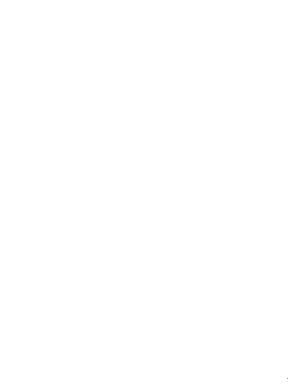

Predicted delta command 0: [ 0.456 -0.001  0.018 -0.012  0.062 -0.001 -0.994]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


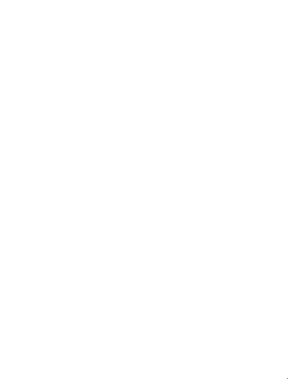

Predicted delta command 0: [ 0.35   0.007  0.034  0.008  0.021  0.003 -0.997]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


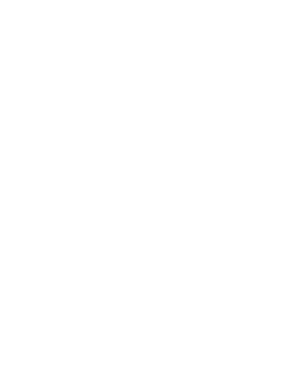

Predicted delta command 0: [ 0.474  0.001  0.103  0.003  0.077  0.003 -1.   ]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


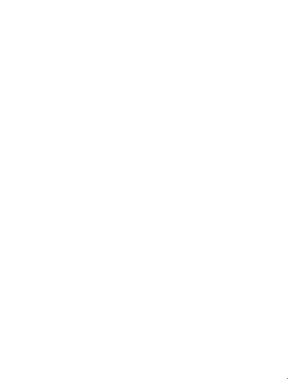

Predicted delta command 0: [ 0.509  0.004  0.057  0.002  0.038  0.001 -1.   ]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


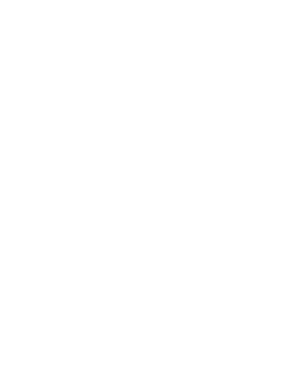

Predicted delta command 0: [ 0.586 -0.007  0.084  0.003  0.046 -0.001 -1.   ]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


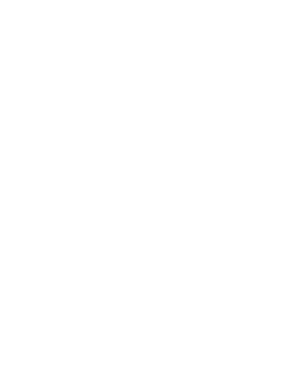

Predicted delta command 0: [ 0.64  -0.007  0.08   0.005  0.01  -0.004 -1.   ]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


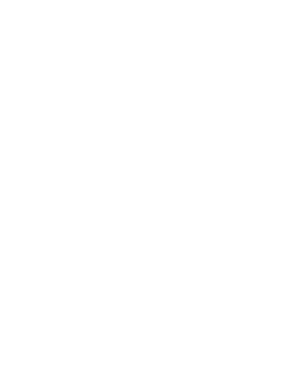

Predicted delta command 0: [ 0.629 -0.009  0.079  0.004  0.009 -0.008 -1.   ]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


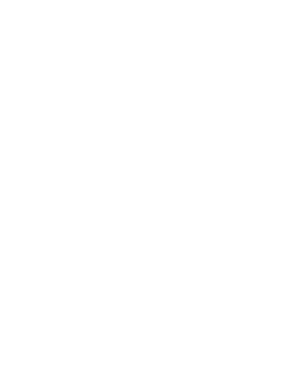

Predicted delta command 0: [ 0.576 -0.004  0.083  0.006  0.004 -0.007 -1.   ]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


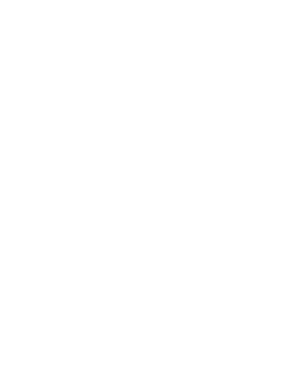

Predicted delta command 0: [ 0.536 -0.001  0.068  0.007 -0.003 -0.007 -1.   ]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


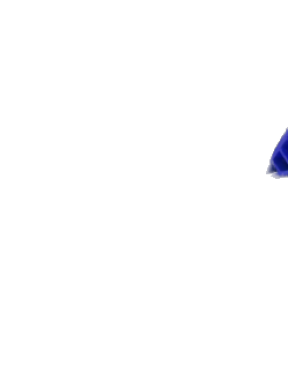

Predicted delta command 0: [ 0.558  0.004  0.052  0.004 -0.007 -0.005 -1.   ]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


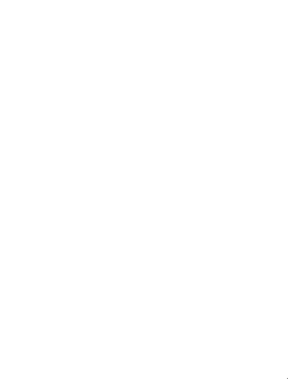

Predicted delta command 0: [ 0.625  0.006  0.013  0.002 -0.004 -0.001 -1.   ]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


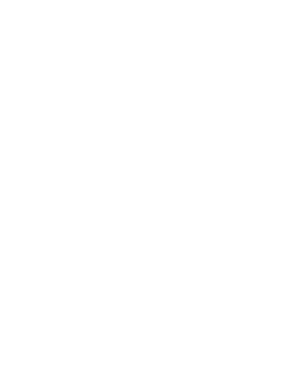

Predicted delta command 0: [ 0.666 -0.002  0.002 -0.004  0.     0.004 -1.   ]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


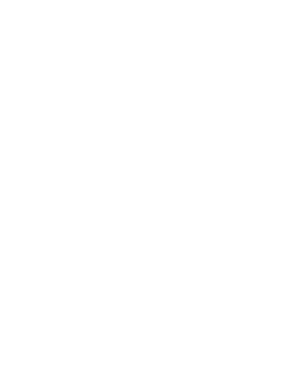

Predicted delta command 0: [ 0.666  0.002 -0.003 -0.01   0.003  0.01  -1.   ]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


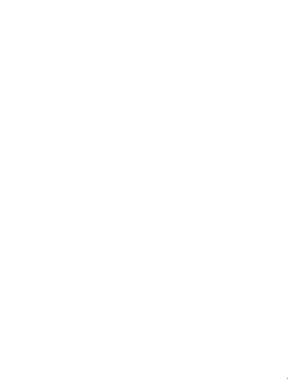

Predicted delta command 0: [ 0.649 -0.001 -0.004 -0.012  0.004  0.008 -1.   ]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


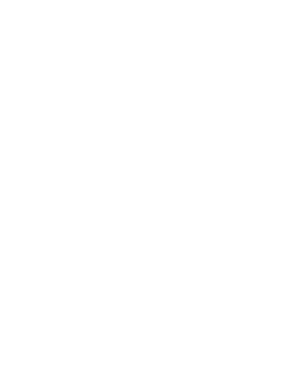

Predicted delta command 0: [ 0.648 -0.003 -0.001 -0.013  0.003  0.006 -1.   ]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


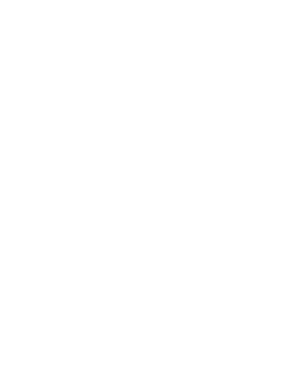

Predicted delta command 0: [ 0.635 -0.009  0.004 -0.012  0.003  0.006 -0.999]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


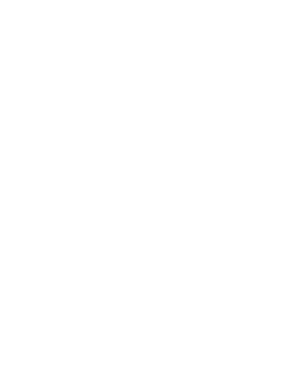

Predicted delta command 0: [ 0.667 -0.014  0.001 -0.009  0.003  0.002 -1.   ]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


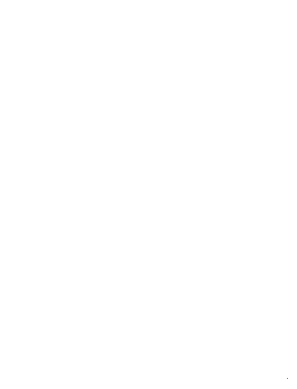

Predicted delta command 0: [ 0.691 -0.01  -0.003 -0.012  0.003  0.005 -1.   ]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


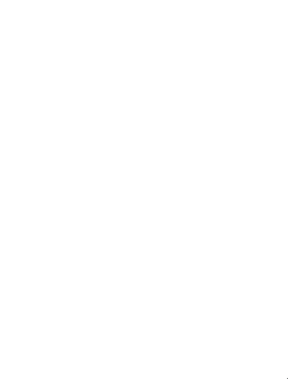

Predicted delta command 0: [ 0.674 -0.008 -0.005 -0.006 -0.001  0.003 -0.999]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


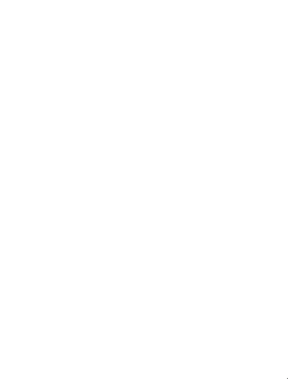

Predicted delta command 0: [ 0.621  0.026  0.005  0.012  0.001  0.008 -1.   ]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


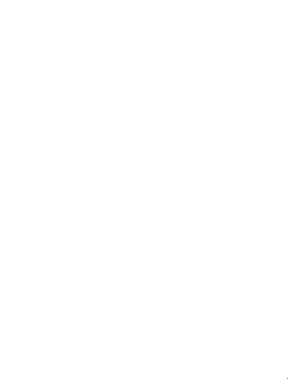

Predicted delta command 0: [ 0.638  0.005  0.017  0.015  0.007  0.005 -1.   ]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


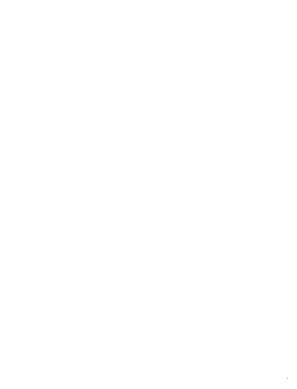

Predicted delta command 0: [ 0.565  0.007  0.024  0.013  0.003  0.003 -0.999]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


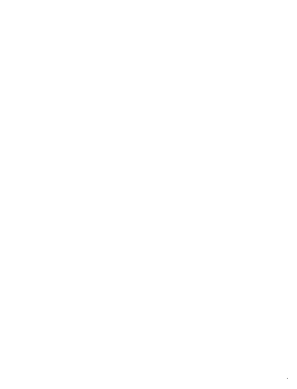

Predicted delta command 0: [ 0.362 -0.008  0.303  0.056  0.027  0.049 -1.   ]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


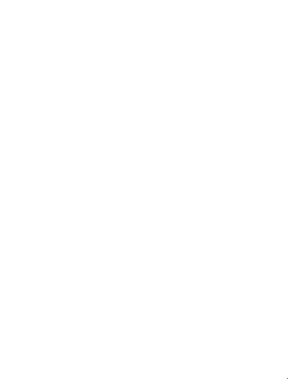

Predicted delta command 0: [ 0.307  0.008  0.346  0.043  0.029  0.049 -1.   ]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


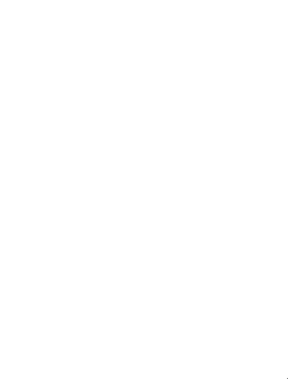

Predicted delta command 0: [ 0.305  0.004  0.266  0.037  0.014  0.026 -1.   ]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


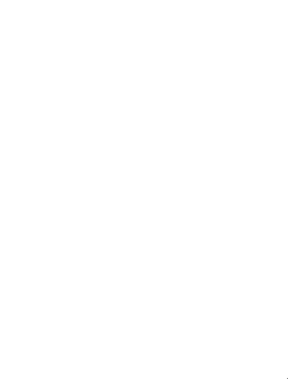

Predicted delta command 0: [ 0.3   -0.001  0.245  0.047  0.008  0.011 -1.   ]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


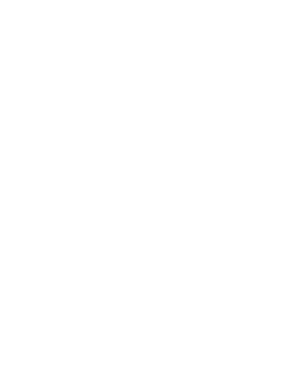

Predicted delta command 0: [ 0.318 -0.043  0.121  0.072  0.005  0.002 -1.   ]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


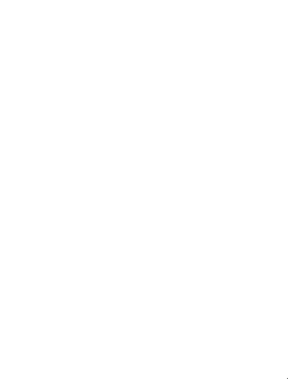

Predicted delta command 0: [ 0.326 -0.049  0.076  0.07   0.004 -0.001 -1.   ]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


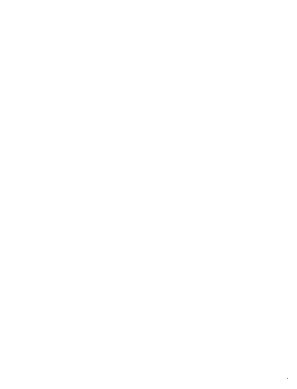

Predicted delta command 0: [ 0.307 -0.059  0.016  0.071 -0.     0.003 -0.997]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


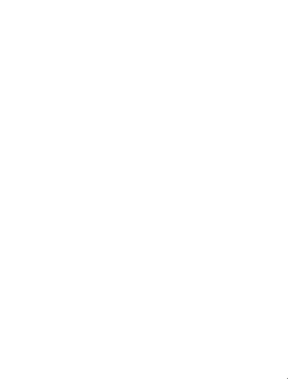

Predicted delta command 0: [ 0.306 -0.066  0.025  0.068 -0.001  0.002 -0.989]
Measured pose safe set check: inside=True
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


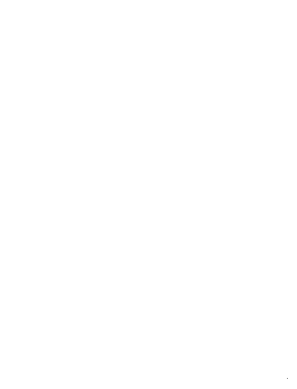

Predicted delta command 0: [ 0.265 -0.041  0.014  0.07   0.001 -0.003  0.991]
Measured pose safe set check: inside=False
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


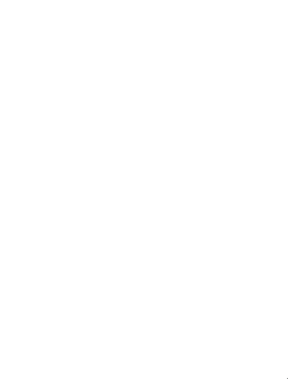

Predicted delta command 0: [ 0.184 -0.023  0.026  0.061  0.004  0.     1.   ]
Measured pose safe set check: inside=False
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


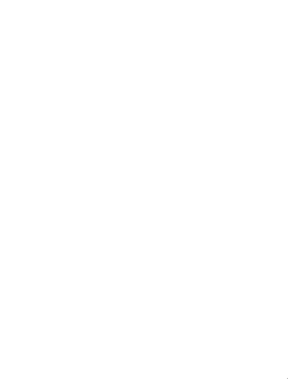

Predicted delta command 0: [ 0.065 -0.01   0.021  0.043  0.001 -0.002  1.   ]
Measured pose safe set check: inside=False
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


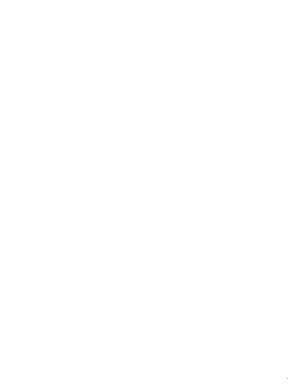

Predicted delta command 0: [ 0.038 -0.015  0.073  0.035  0.002 -0.005  1.   ]
Measured pose safe set check: inside=False
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


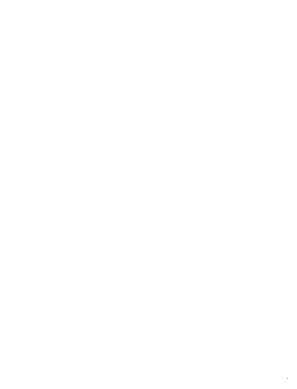

Predicted delta command 0: [ 0.024 -0.015  0.062  0.035 -0.001 -0.005  1.   ]
Measured pose safe set check: inside=False
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


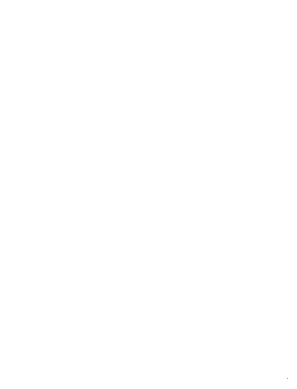

Predicted delta command 0: [ 0.031 -0.02   0.073  0.035  0.002 -0.005  1.   ]
Measured pose safe set check: inside=False
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


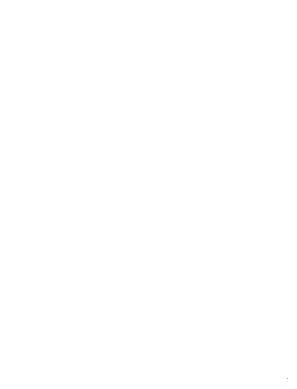

Predicted delta command 0: [ 0.025 -0.014  0.071  0.034 -0.002 -0.005  0.996]
Measured pose safe set check: inside=False
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


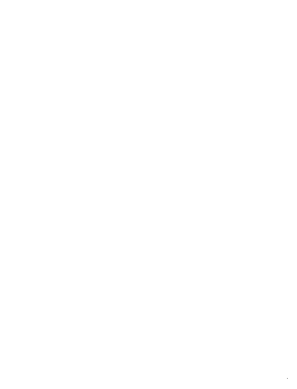

Predicted delta command 0: [ 0.02  -0.014  0.083  0.03  -0.003 -0.004  0.999]
Measured pose safe set check: inside=False
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


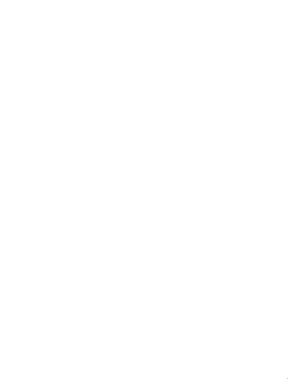

Predicted delta command 0: [ 0.018 -0.022  0.061  0.026  0.001 -0.002  1.   ]
Measured pose safe set check: inside=False
from controller:  [0. 0. 0.] [0. 0. 0.]
(320, 240, 3)


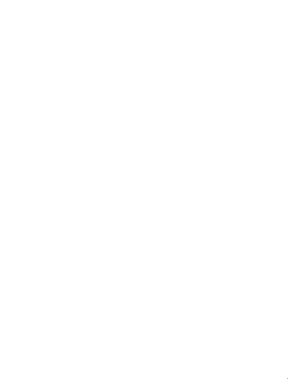

KeyboardInterrupt: 

In [ ]:
import time
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import ConvexHull
from scipy.spatial.transform import Rotation as R
import os
import torch
from PIL import Image
import cv2
from carvekit.api.high import HiInterface

###############################################################################
# 1) Background Removal Utility (unchanged)
###############################################################################
def remove_background_from_image(input_image, temp_filename="temp_bg.png", device=None, bg_interface=None):
    if not isinstance(input_image, Image.Image):
        input_image = Image.fromarray(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    input_image.save(temp_filename)
    processed_image = bg_interface([temp_filename])[0]
    os.remove(temp_filename)
    return processed_image

###############################################################################
# 2) Forward Kinematics & Safe-Set Utilities (unchanged except for comments)
###############################################################################
def dh_transform(a, alpha, d, theta):
    return np.array([
        [ np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha),  a*np.cos(theta)],
        [ np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha),  a*np.sin(theta)],
        [ 0,              np.sin(alpha),                np.cos(alpha),                d              ],
        [ 0,              0,                            0,                            1              ]
    ], dtype=float)

def franka_forward_kinematics(joint_angles):
    q1, q2, q3, q4, q5, q6, q7 = joint_angles
    T1 = dh_transform(a=0,       alpha=0,         d=0.333,   theta=q1)
    T2 = dh_transform(a=0,       alpha=-np.pi/2,  d=0,       theta=q2)
    T3 = dh_transform(a=0,       alpha=np.pi/2,   d=0.316,   theta=q3)
    T4 = dh_transform(a=0.0825,  alpha=np.pi/2,   d=0,       theta=q4)
    T5 = dh_transform(a=-0.0825, alpha=-np.pi/2,  d=0.384,   theta=q5)
    T6 = dh_transform(a=0,       alpha=np.pi/2,   d=0,       theta=q6)
    T7 = dh_transform(a=0.088,   alpha=np.pi/2,   d=0,       theta=q7)
    T_flange = dh_transform(a=0, alpha=0, d=0.107, theta=0)
    Rz_neg_45 = dh_transform(a=0, alpha=0, d=0, theta=-np.pi/4)
    T_panda_hand = T1 @ T2 @ T3 @ T4 @ T5 @ T6 @ T7 @ T_flange @ Rz_neg_45
    return T_panda_hand

def joint_angles_to_end_effector_pose(joint_angles):
    T = franka_forward_kinematics(joint_angles)
    x, y, z = T[0, 3], T[1, 3], T[2, 3]
    rot_mat = T[:3, :3]
    quat = R.from_matrix(rot_mat).as_quat()  # [qx, qy, qz, qw]
    return np.array([x, y, z, quat[0], quat[1], quat[2], quat[3]], dtype=float)

def normalize_quaternion(q):
    norm = np.linalg.norm(q)
    return q / norm if norm > 1e-6 else np.array([0, 0, 0, 1])

def pose7d_to_6d(pose7d):
    pos = np.array(pose7d[:3])
    quat = np.array(pose7d[3:7])
    norm = np.linalg.norm(quat)
    if norm < 1e-6:
        quat = np.array([0, 0, 0, 1])
    else:
        quat = quat / norm
    rotvec = R.from_quat(quat).as_rotvec()
    return np.hstack([pos, rotvec])

# DO NOT CHANGE THIS FUNCTION
# def is_pose_in_safe_set_6d(query_6d, hull_equations, tol=1e-8):
#     query_pos = np.array(query_6d[:3])
#     A = hull_equations[:, :-1]
#     b = hull_equations[:, -1]
#     norms = np.linalg.norm(A, axis=1)
#     distances = (A.dot(query_pos) + b) / norms
#     inside = np.all(distances <= tol)
#     return inside, distances

def is_pose_in_safe_set_6d(query_6d, hull_equations, tol=1e-8):
    """
    Checks if a 6D pose [x, y, z, rx, ry, rz] is inside the safe set,
    given the convex hull equations computed in 6D.

    Parameters:
        query_6d (array-like): 6D pose, e.g., [x, y, z, rx, ry, rz].
        hull_equations (np.ndarray): Array of shape (m,7) where each row is [A1,...,A6, b].
        tol (float): Tolerance for determining inclusion.

    Returns:
        inside (bool): True if the pose satisfies all inequalities.
        distances (np.ndarray): The signed distances from the query to each facet.
    """
    query_point = np.array(query_6d)  # Full 6D vector.
    A = hull_equations[:, :-1]       # (m, 6) matrix of facet normals.
    b = hull_equations[:, -1]        # (m,) offsets.
    norms = np.linalg.norm(A, axis=1)
    distances = (A.dot(query_point) + b) / norms
    inside = np.all(distances <= tol)
    return inside, distances



def load_safe_set(file_path="safe_set_6d.npz"):
    data = np.load(file_path)
    return data["safe_set"], data["hull_equations"], data["hull_vertices"]

###############################################################################
# 3) Visualization Utility (unchanged)
###############################################################################
def visualize_policy_predictions(safe_set, predicted_poses_7d, inside_flags, title="Policy Predictions vs. Safe Set"):
    hull_3d = ConvexHull(safe_set[:, :3])
    fig = go.Figure()
    fig.add_trace(go.Mesh3d(
        x=safe_set[:, 0],
        y=safe_set[:, 1],
        z=safe_set[:, 2],
        i=hull_3d.simplices[:, 0],
        j=hull_3d.simplices[:, 1],
        k=hull_3d.simplices[:, 2],
        opacity=0.3,
        color='lightblue',
        name='Safe Set Hull'
    ))
    predicted_positions = predicted_poses_7d[:, :3]
    colors = ["green" if flag else "red" for flag in inside_flags]
    fig.add_trace(go.Scatter3d(
        x=predicted_positions[:, 0],
        y=predicted_positions[:, 1],
        z=predicted_positions[:, 2],
        mode='markers+lines',
        marker=dict(size=5, color=colors),
        line=dict(color='gray', width=2),
        name='EEF Poses (Real Joints)'
    ))
    fig.update_layout(
        title=title,
        scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z")
    )
    fig.show()

# def iterative_push_delta_until_outside(current_pose, delta_cmd, hull_equations,
#                                        robot_interface, controller_type, controller_cfg,
#                                        tol=1e-1, margin=1e-3, max_iter=50):
#     """
#     Given the current absolute pose (7D) and a predicted delta command (7D),
#     this function executes a push in full 6D until the measured absolute pose is outside
#     the safe set. It operates by converting the inputs to 6D (position + rotation vector),
#     updating the delta command iteratively, and then converting back to 7D.
    
#     Parameters:
#         current_pose: Current absolute pose (7D: [x, y, z, qx, qy, qz, qw]).
#         delta_cmd: Predicted delta command (7D) – the command to add to current_pose.
#         hull_equations: Convex hull equations in 6D (each row: [A1,...,A6, b]).
#         robot_interface: The robot interface object used for sending control commands.
#         controller_type: Controller type (passed to robot_interface.control).
#         controller_cfg: Controller configuration.
#         tol: Tolerance for safe-set inclusion (e.g. 1e-1). A point is considered outside if any
#              facet has a positive signed distance when tol=0.0.
#         margin: Additional margin to ensure the command crosses the boundary.
#         max_iter: Maximum iterations.
    
#     Returns:
#         new_delta_7d: The updated delta command (7D) computed as (new_abs_pose - current_pose).
#         push_direction: The normalized overall push direction (6D) applied (if any), or None if no push was needed.
#         final_abs_pose: The final absolute pose (7D) after push.
#     """
#     # Convert current_pose (7D) to 6D.
#     current_pose_6d = pose7d_to_6d(current_pose)
    
#     # Convert delta_cmd (7D) to 6D.
#     delta_translation = delta_cmd[:3]
#     delimgta_rotvec = R.from_quat(delta_cmd[3:7]).as_rotvec()
#     delta_cmd_6d = np.hstack([delta_translation, delta_rotvec])
    
#     # Start with the initial 6D delta.
#     new_delta_6d = np.copy(delta_cmd_6d)
#     total_shift = np.zeros(6)
    
#     for _ in range(max_iter):
#         # Compute the predicted absolute 6D pose.
#         predicted_abs_6d = current_pose_6d + new_delta_6d
        
#         # Convert new_delta_6d back to 7D command for execution.
#         new_delta_translation = new_delta_6d[:3]
#         new_delta_quat = R.from_rotvec(new_delta_6d[3:]).as_quat()
#         new_delta_7d = np.hstack([new_delta_translation, new_delta_quat])
        
#         # Send the delta command.
#         robot_interface.control(controller_type=controller_type,
#                                   action=new_delta_7d,
#                                   controller_cfg=controller_cfg)
#         time.sleep(0.05)
        
#         # Read the measured state.
#         js = robot_interface.last_q
#         if js is None:
#             continue  # Try again if no feedback.
#         measured_pose = joint_angles_to_end_effector_pose(js)
#         measured_pose_6d = pose7d_to_6d(measured_pose)
        
#         # Check if the measured 6D pose is outside the safe set.
#         inside, distances = is_pose_in_safe_set_6d(measured_pose_6d, hull_equations, tol)
#         print("Push iteration: measured safe-set check: inside =", inside, "distances =", distances)
#         if not inside:
#             break
        
#         # Compute additional required shift in 6D.
#         i_max = np.argmax(distances)
#         d_max = distances[i_max]
#         A_i = hull_equations[i_max, :-1]  # Should be a 6D vector.
#         norm_A = np.linalg.norm(A_i)
#         additional_shift = (tol - d_max + margin) * (A_i / norm_A)
#         total_shift += additional_shift
#         new_delta_6d += additional_shift  # Update entire 6D delta.
#     else:
#         print("Warning: Maximum iterations reached; command may still be inside.")
    
#     push_direction = None
#     if np.linalg.norm(total_shift) > 0:
#         push_direction = total_shift / np.linalg.norm(total_shift)
    
#     # Final absolute pose in 6D.
#     final_abs_6d = current_pose_6d + new_delta_6d
#     # Convert new_delta_6d back to 7D.
#     new_delta_translation = new_delta_6d[:3]
#     new_delta_quat = R.from_rotvec(new_delta_6d[3:]).as_quat()
#     new_delta_7d = np.hstack([new_delta_translation, new_delta_quat])
#     # Convert final_abs_6d to 7D absolute pose.
#     final_abs_translation = final_abs_6d[:3]
#     final_abs_quat = R.from_rotvec(final_abs_6d[3:]).as_quat()
#     final_abs_pose = np.hstack([final_abs_translation, final_abs_quat])
    
#     return new_delta_7d, push_direction, final_abs_pose

def iterative_push_delta_until_outside(current_pose, delta_cmd, hull_equations,
                                       robot_interface, controller_type, controller_cfg,
                                       tol=1e-1, margin=1e-3, max_iter=50,
                                       pos_weight=0.1, rot_weight=1.0):
    """
    Given the current absolute pose (7D) and a predicted delta command (7D),
    this function executes the delta push in full 6D until the measured absolute pose
    is outside the safe set. The correction is weighted so that the position is changed minimally
    while the orientation is corrected more.
    
    Parameters:
        current_pose: Current absolute pose (7D: [x, y, z, qx, qy, qz, qw]).
        delta_cmd: Predicted delta command (7D) – the command to be added to current_pose.
        hull_equations: Convex hull equations in 6D (each row: [A1,...,A6, b]).
        robot_interface: The robot interface object (used to send control commands).
        controller_type: Controller type (passed to robot_interface.control).
        controller_cfg: Controller configuration.
        tol: Tolerance for safe-set inclusion (e.g. 1e-1).
        margin: Additional margin to ensure the command crosses the boundary.
        max_iter: Maximum iterations.
        pos_weight: Weight for the position components (applied to the correction vector).
        rot_weight: Weight for the orientation components.
        
    Returns:
        new_delta_7d: The updated delta command (7D), computed as (new_abs_pose - current_pose).
        push_direction: The normalized overall push direction (6D) applied, or None if no push was needed.
        final_abs_pose: The final absolute pose (7D) after the push.
    """
    # Convert current_pose (7D) to 6D.
    current_pose_6d = pose7d_to_6d(current_pose)
    
    # Convert delta_cmd (7D) to 6D.
    delta_translation = delta_cmd[:3]
    delta_rotvec = R.from_quat(delta_cmd[3:7]).as_rotvec()
    delta_cmd_6d = np.hstack([delta_translation, delta_rotvec])
    
    # Start with the initial 6D delta.
    new_delta_6d = np.copy(delta_cmd_6d)
    total_shift = np.zeros(6)
    
    for _ in range(max_iter):
        # Compute the predicted absolute 6D pose.
        predicted_abs_6d = current_pose_6d + new_delta_6d
        
        # Convert the updated delta command to 7D for execution.
        new_delta_translation = new_delta_6d[:3]
        new_delta_quat = R.from_rotvec(new_delta_6d[3:]).as_quat()
        new_delta_7d = np.hstack([new_delta_translation, new_delta_quat])
        
        # Send the delta command.
        robot_interface.control(controller_type=controller_type,
                                  action=new_delta_7d,
                                  controller_cfg=controller_cfg)
        time.sleep(0.05)
        
        # Read the measured state.
        js = robot_interface.last_q
        if js is None:
            continue  # Retry if no feedback.
        measured_pose = joint_angles_to_end_effector_pose(js)
        measured_pose_6d = pose7d_to_6d(measured_pose)
        
        # Check if the measured 6D pose is outside the safe set.
        inside, distances = is_pose_in_safe_set_6d(measured_pose_6d, hull_equations, tol)
        print("Push iteration: measured safe-set check: inside =", inside, "distances =", distances)
        if not inside:
            break
        
        # Compute the additional required shift based on the measured pose.
        i_max = np.argmax(distances)
        d_max = distances[i_max]
        A_i = hull_equations[i_max, :-1]  # This is a 6D vector.
        norm_A = np.linalg.norm(A_i)
        
        # Weight the correction: reduce the position correction relative to orientation.
        weights = np.array([pos_weight, pos_weight, pos_weight, rot_weight, rot_weight, rot_weight])
        weighted_A_i = A_i * weights
        norm_weighted = np.linalg.norm(weighted_A_i)
        additional_shift = (tol - d_max + margin) * (weighted_A_i / norm_weighted)
        
        total_shift += additional_shift
        new_delta_6d += additional_shift  # Update the entire 6D delta.
    else:
        print("Warning: Maximum iterations reached; command may still be inside.")
    
    push_direction = None
    if np.linalg.norm(total_shift) > 0:
        push_direction = total_shift / np.linalg.norm(total_shift)
    
    # Convert new_delta_6d back to a 7D delta command.
    new_delta_translation = new_delta_6d[:3]
    new_delta_quat = R.from_rotvec(new_delta_6d[3:]).as_quat()
    new_delta_7d = np.hstack([new_delta_translation, new_delta_quat])
    
    # Compute final absolute pose in 7D.
    final_abs_6d = current_pose_6d + new_delta_6d
    final_abs_translation = final_abs_6d[:3]
    final_abs_quat = R.from_rotvec(final_abs_6d[3:]).as_quat()
    final_abs_pose = np.hstack([final_abs_translation, final_abs_quat])
    
    return new_delta_7d, push_direction, final_abs_pose


###############################################################################
# 5) Main Execution and Control Loop
###############################################################################
# Load safe set from file (update path as needed)
safe_set_file = '/home/franka_deoxys/riad/safe_set_6d_panda_hand.npz'
safe_set,hull_equations, _ = load_safe_set(safe_set_file)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
bg_interface = HiInterface(
    object_type="hairs-like",
    batch_size_seg=5,
    batch_size_matting=1,
    device=device,
    seg_mask_size=640,
    matting_mask_size=2056,
    trimap_prob_threshold=231,
    trimap_dilation=30,
    trimap_erosion_iters=5,
    fp16=False
)

# Reset robot and policy (assumed to be defined elsewhere)
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions)
set_gripper(open=True)
policy.reset()

images = []
all_poses_7d = []
all_inside_flags = []

# We will apply the delta push exactly once—after 4 steps.
min_steps_before_push = 3
has_pushed = False  # flag to ensure push happens only once
step_count = 0

# Main control loop
for _ in range(50):
    # 1) Acquire user input (assumed function input2action defined elsewhere)
    action, grasp = input2action(device=spacemouse, controller_type=controller_type)
    if action is None:
        break
    if len(robot_interface._state_buffer) == 0:
        continue

    # 2) Get observation
    obs_dict = get_current_obs(robot_interface)
    img = obs_dict['eye_in_hand_rgb_bg_removed']
    
    img = np.transpose(img, (1, 2, 0))
    print(img.shape)
    img = Image.fromarray(img)
    img = remove_background_from_image(img,bg_interface=bg_interface)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()
    images.append(img)
    obs = framestacker.add_new_obs(obs_dict)

    # 3) Policy predicts delta commands (format may vary: delta pose, etc.)
    action_pred = predict_action(obs)
    
    # Before processing commands, get the current absolute pose from the robot state.
    js_current = robot_interface.last_q
    if js_current is not None:
        current_pose = joint_angles_to_end_effector_pose(js_current)
    else:
        # If we cannot get the current pose, we skip delta adjustments.
        current_pose = np.zeros(7)
    
    # 4) Process each predicted delta command (e.g., first 4 commands)
    for i, single_cmd in enumerate(action_pred[:1]):
        # print(f"Predicted delta command {i}:", single_cmd)
        # If we haven't pushed yet, and we've reached min_steps_before_push, apply iterative push to the delta command.
        if (not has_pushed) and (step_count >= min_steps_before_push):
            new_delta, push_direction, new_abs_pose = iterative_push_delta_until_outside(
                current_pose, single_cmd, hull_equations,robot_interface, controller_type, controller_cfg, tol=1e-1, margin=1e-4, max_iter=500
            )
            print("Applied iterative push on delta command. Overall push direction (position):", push_direction)
            print("Pushed delta ",new_delta )
            robot_interface.control(controller_type=controller_type,
                                      action=new_delta,
                                      controller_cfg=controller_cfg)
            has_pushed = True
        else:
            # Otherwise, send the nominal delta command.
            robot_interface.control(controller_type=controller_type,
                                      action=single_cmd,
                                      controller_cfg=controller_cfg)
        time.sleep(0.05)

        # (Optional) Read actual joint angles for visualization/logging.
        js_real = robot_interface.last_q
        if js_real is None:
            print("No joint angles read. Skipping visualization update.")
            continue
        eef_pose_7d = joint_angles_to_end_effector_pose(js_real)
        all_poses_7d.append(eef_pose_7d)
        # For logging, check safe-set inclusion (using only position).
        eef_pose_6d = pose7d_to_6d(eef_pose_7d)
        inside, distances = is_pose_in_safe_set_6d(eef_pose_6d, hull_equations, tol=1e-1)
        all_inside_flags.append(inside)
        print(f"Measured pose safe set check: inside={inside}")

    step_count += 1

robot_interface.close()

# Optionally, visualize the collected data.
# visualize_policy_predictions(safe_set, np.array(all_poses_7d), all_inside_flags)


In [63]:
def load_safe_set(file_path="safe_set_6d.npz"):
    data = np.load(file_path)
    print("Keys in the data file:", data.files)
    return data["safe_set"], data["hull_equations"], data["hull_vertices"]


In [64]:
safe_set_file = '/home/franka_deoxys/riad/safe_set_6d_fv_rg.npz'
safe_set, hull_equations, _ = load_safe_set(safe_set_file)

Keys in the data file: ['safe_set', 'hull_equations', 'hull_vertices']


In [66]:
safe_set

array([[ 0.606, -0.08 ,  0.345],
       [ 0.606, -0.08 ,  0.345],
       [ 0.606, -0.08 ,  0.345],
       ...,
       [-0.586,  0.16 ,  0.4  ],
       [-0.586,  0.16 ,  0.4  ],
       [-0.586,  0.16 ,  0.4  ]])

In [25]:
import os
import torch
from PIL import Image
import cv2
from carvekit.api.high import HiInterface

def remove_background_from_image(input_image, temp_filename="temp_bg.png", device=None,bg_interface=None):
    """
    Removes the background from the provided image using HiInterface and composites it on a white background.
    
    Parameters:
        input_image (PIL.Image.Image or np.ndarray): The input image. If provided as a NumPy array (BGR),
            it will be converted to a PIL image.
        temp_filename (str): Temporary filename to save the image.
        device (str): Device to use ('cuda' or 'cpu'). If None, it selects automatically.
    
    Returns:
        PIL.Image.Image: The background removed image (composited on a white background).
    """
    
    
    # Convert input_image to PIL Image if necessary.
    if not isinstance(input_image, Image.Image):
        # Assume input image is in BGR (OpenCV format); convert to RGB and then to PIL.
        input_image = Image.fromarray(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    
    # Save the input image temporarily.
    input_image.save(temp_filename)
    
    
    
    # Process the image. HiInterface expects a list of file paths.
    processed_image = bg_interface([temp_filename])[0]
    
    # Optionally, remove the temporary file.
    os.remove(temp_filename)
    
    return processed_image

# Example usage:

# Load an example image (you can use a local file)
input_path = "/home/franka_deoxys/Downloads/toy_duck.jpg"
img = Image.open(input_path)
# Ensure device is set



    # processed_img.show()


In [26]:
# Remove background
import time
start = time.time()
print(img.shape)
processed_img = remove_background_from_image(img,bg_interface=bg_interface)
end = time.time()

print("Time taken ",end-start)

# Save or display the processed image
processed_img.save("bg_removed_image.png")

AttributeError: shape